<a href="https://colab.research.google.com/github/sofiaisyarahma/AI-Powered-Talent-Match/blob/main/AI_Powered_Talent_Match.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-Powered Talent Match


### Author:
**[Sofi Aisyarahma](https://www.linkedin.com/in/sofiaisyarahma/)**

### Description:
Company X is developing a Talent Match Intelligence system to help leaders identify what makes top-performing employees
successful and to find individuals who share those characteristics for succession.

### Outline:
1. Data Extraction
2. Data Cleaning
3. Exploratory Data Analysis
4. Machine Learning Model
5. Insights and Business Recommendations

### Objective:
1. Discover the pattern of success
    - Use data exploration and visualization to see how high performers differ from others.
    - Compare across:
       + Competency pillars (competencies_yearly, dim_competency_pillars)
       + Psychometric data (papi_scores, profiles_psych)
       + Behavioral data (strengths)
       + Contextual data (grade, education, years_of_service_months)
    - Outcome → a “Success Formula” that explains what drives high performance.
2. Operationalize the logic in SQL
    - Managers choose “benchmark employees” (rating = 5).
    - Write a SQL script that:
        + Calculates how closely every employee matches the benchmark.
        + Uses CTEs (Common Table Expressions) for clarity.
        + Produces per-variable, per-group, and final match % scores.
3. Build an AI-powered dashboard/app
     - Use tools like Streamlit or similar.
     - Show:
       + Ranked candidate list by match %.
       + Visuals (radar, heatmap, comparison charts).
       + AI-generated job profile and key competencies.
     - The app must take new input (role, benchmark employees) and recompute dynamically.


### Dataset: [Study Case DA](https://docs.google.com/spreadsheets/d/1WEEjTL02EhUvZtyhQ3xshYrvKa-d6900GzIqXLZzU1o/)


## Import Libraries

In [371]:
# Import pandas library for data manipulation and analysis
import pandas as pd

# Import gdown library for downloading files from Google Drive (if needed)
import gdown

# Import numpy library for scientific computing and array manipulation
import numpy as np

# Import datetime library for working with dates and times
from datetime import datetime

# Import matplotlib.pyplot for creating visualizations (plots)
import matplotlib.pyplot as plt

# Import seaborn library for creating statistical data visualizations
import seaborn as sns

# Import warnings library to suppress warnings (use with caution)
import warnings
warnings.filterwarnings("ignore")  # **Caution:** May hide important warnings

# Set pandas display options to show all columns in the DataFrame (might be inconvenient for large datasets)
pd.set_option('display.max_columns', None)

# Import libraries from scipy.stats for statistical tests
from scipy.stats import shapiro, skew

plt.rcParams['axes.grid'] = False

# Install and import dependencies
!pip install --quiet gspread gspread_dataframe

# impoort gspread_dataframe library
import gspread
from gspread_dataframe import get_as_dataframe

In [372]:
# Authorize access to Google Sheets
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

## 1. Data Extraction

### 1.1 Import Dataset (GoogleSheets)

In [373]:
# Open Google Sheets file by URL
spreadsheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/1WEEjTL02EhUvZtyhQ3xshYrvKa-d6900GzIqXLZzU1o/edit?usp=sharing")

In [374]:
# List all available sheets
worksheet_list = spreadsheet.worksheets()
for ws in worksheet_list:
    print(ws.title)

Talent Variable (TV) & Talent Group Variable (TGV)
dim_companies
dim_areas
dim_positions
dim_departments
dim_divisions
dim_directorates
dim_grades
dim_education
dim_majors
dim_competency_pillars
employees
profiles_psych
papi_scores
strengths
performance_yearly
competencies_yearly


In [375]:
# Load all sheets automatically
# Create a dictionary to store all sheets as pandas DataFrames
dfs = {}

for ws in spreadsheet.worksheets():
    title = ws.title
    df = get_as_dataframe(ws)
    dfs[title] = df

# Check which DataFrames you have
dfs.keys()



dict_keys(['Talent Variable (TV) & Talent Group Variable (TGV)', 'dim_companies', 'dim_areas', 'dim_positions', 'dim_departments', 'dim_divisions', 'dim_directorates', 'dim_grades', 'dim_education', 'dim_majors', 'dim_competency_pillars', 'employees', 'profiles_psych', 'papi_scores', 'strengths', 'performance_yearly', 'competencies_yearly'])

In [376]:
# Assign each sheet to a dataframe variable
tv_tgv              = dfs['Talent Variable (TV) & Talent Group Variable (TGV)']
dim_companies       = dfs['dim_companies']
dim_areas           = dfs['dim_areas']
dim_positions       = dfs['dim_positions']
dim_departments     = dfs['dim_departments']
dim_divisions       = dfs['dim_divisions']
dim_directorates    = dfs['dim_directorates']
dim_grades          = dfs['dim_grades']
dim_education       = dfs['dim_education']
dim_majors          = dfs['dim_majors']
dim_competency_pillars = dfs['dim_competency_pillars']
employees           = dfs['employees']
profiles_psych      = dfs['profiles_psych']
papi_scores         = dfs['papi_scores']
strengths           = dfs['strengths']
performance_yearly  = dfs['performance_yearly']
competencies_yearly = dfs['competencies_yearly']

In [377]:
# Make a copy of the original data for data cleaning
df_tv_tgv              = tv_tgv.copy()
df_dim_companies       = dim_companies.copy()
df_dim_areas           = dim_areas.copy()
df_dim_positions       = dim_positions.copy()
df_dim_departments     = dim_departments.copy()
df_dim_divisions       = dim_divisions.copy()
df_dim_directorates    = dim_directorates.copy()
df_dim_grades          = dim_grades.copy()
df_dim_education       = dim_education.copy()
df_dim_majors          = dim_majors.copy()
df_dim_competency_pillars = dim_competency_pillars.copy()
df_employees           = employees.copy()
df_profiles_psych      = profiles_psych.copy()
df_papi_scores         = papi_scores.copy()
df_strengths           = strengths.copy()
df_performance_yearly  = performance_yearly.copy()
df_competencies_yearly = competencies_yearly.copy()

In [378]:
df_tv_tgv.head(2)

,Test as Talent Variable (TV),Sub-test,Meaning,Behavior Example,Talent Group Variable (TGV),Note
0,Pauli,Initial Performance,Measures starting accuracy/speed,"Quick starter shows immediate focus, slower st...",Motivation & Drive,NaN
1,MBTI,Extraversion,Energy from social interaction,"Talkative, networking",Leadership & Influence,NaN


In [379]:
df_dim_companies.head(2)

,company_id,name
0,1.0,PT Aurora Beauty Indonesia
1,2.0,PT VASKA Wellness


In [380]:
df_dim_areas.head(2)

,area_id,name
0,1.0,Distribution
1,2.0,HQ


In [381]:
df_dim_positions.head(2)

,position_id,name
0,1.0,Brand Executive
1,2.0,Data Analyst


In [382]:
df_dim_departments.head(2)

,department_id,name
0,1.0,Finance
1,2.0,HR


In [383]:
df_dim_divisions.head(2)

,division_id,name
0,1.0,Digital Marketing
1,2.0,Operations


In [384]:
df_dim_directorates.head(2)

,directorate_id,name
0,1.0,Commercial
1,2.0,HR & Corp Affairs


In [385]:
df_dim_grades.head(2)

,grade_id,name
0,1.0,III
1,2.0,IV


In [386]:
df_dim_education.head(2)

,education_id,name
0,1.0,D3
1,2.0,S1


In [387]:
df_dim_majors.head(2)

,major_id,name
0,1.0,Business
1,2.0,Design


In [388]:
df_dim_competency_pillars.head(2)

,pillar_code,pillar_label
0,GDR,Growth Drive & Resilience
1,CEX,Curiosity & Experimentation


In [389]:
df_employees.head(2)

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,education_id,major_id,years_of_service_months
0,EMP100000,Rendra Pratama,806137.0,1.0,4.0,1.0,6.0,3.0,3.0,2.0,3.0,1.0,64.0
1,EMP100001,Wulan Setiawan,476388.0,4.0,4.0,4.0,5.0,5.0,3.0,1.0,1.0,2.0,16.0


In [390]:
df_profiles_psych.head(2)

,employee_id,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki
0,EMP100000,86.0,75.0,SI,Steadiness-Influencer,NaN,94.0,33.0,2.0
1,EMP100001,48.0,52.0,DS,Dominant-Steadiness,INTP,94.0,17.0,3.0


In [391]:
df_papi_scores.head(2)

,employee_id,scale_code,score
0,EMP100000,Papi_N,2.0
1,EMP100001,Papi_N,8.0


In [392]:
df_strengths.head(2)

,employee_id,rank,theme
0,EMP100000,1.0,NaN
1,EMP100001,1.0,Responsibility


In [393]:
df_performance_yearly.head(2)

,employee_id,rating,year
0,EMP100000,2.0,2021.0
1,EMP100001,NaN,2021.0


In [394]:
df_competencies_yearly.head(2)

,employee_id,score,pillar_code,year
0,EMP100000,2.0,GDR,2021.0
1,EMP100001,NaN,GDR,2021.0


## 2. Data Cleaning and Feature Engineering

### 2.1 Merge Data

#### 2.1.1 Merge Data For Employeee Table

*Since we want to analyze the employee table, we will join the name of id from employee table and and profile_psych table*
*Thats why we use left join.*

In [395]:
# Merge the table with df_dim_companies
df_merged = df_employees.merge(df_dim_companies, how='left', left_on =['company_id'], right_on = ['company_id'])
# Rename specific columns
df_merged.rename(columns={'name': 'company'}, inplace=True)
# Merge the table with df_dim_areas
df_merged = df_merged.merge(df_dim_areas, how='left', left_on =['area_id'], right_on = ['area_id'])
# Rename specific columns
df_merged.rename(columns={'name': 'area'}, inplace=True)
# Merge the table with dim_positions
df_merged = df_merged.merge(dim_positions, how='left', left_on =['position_id'], right_on = ['position_id'])
# Rename specific columns
df_merged.rename(columns={'name': 'position'}, inplace=True)
# Merge the table with df_dim_departments
df_merged = df_merged.merge(df_dim_departments, how='left', left_on =['department_id'], right_on = ['department_id'])
# Rename specific columns
df_merged.rename(columns={'name': 'department'}, inplace=True)
# Merge the table with df_dim_divisions
df_merged = df_merged.merge(df_dim_divisions, how='left', left_on =['division_id'], right_on = ['division_id'])
# Rename specific columns
df_merged.rename(columns={'name': 'division'}, inplace=True)
# Merge the table with df_dim_directorates
df_merged = df_merged.merge(df_dim_directorates, how='left', left_on =['directorate_id'], right_on = ['directorate_id'])
# Rename specific columns
df_merged.rename(columns={'name': 'directorate'}, inplace=True)
# Merge the table with df_dim_grades
df_merged = df_merged.merge(df_dim_grades, how='left', left_on =['grade_id'], right_on = ['grade_id'])
# Rename specific columns
df_merged.rename(columns={'name': 'grade'}, inplace=True)
# Merge the table with df_dim_education
df_merged = df_merged.merge(df_dim_education, how='left', left_on =['education_id'], right_on = ['education_id'])
# Rename specific columns
df_merged.rename(columns={'name': 'education'}, inplace=True)
# Merge the table with df_dim_majors
df_merged = df_merged.merge(df_dim_majors, how='left', left_on =['major_id'], right_on = ['major_id'])
# Rename specific columns
df_merged.rename(columns={'name': 'major'}, inplace=True)
# Merge the table with df_profiles_psych
df_merged = df_merged.merge(df_profiles_psych, how='left', left_on =['employee_id'], right_on = ['employee_id'])
# Drop multiple columns
df_merged.drop(columns=['company_id', 'area_id', 'position_id', 'department_id', 'division_id', 'directorate_id', 'grade_id', 'education_id', 'major_id'], inplace=True)
# Show the head of the data
df_merged.head()

,employee_id,fullname,nip,years_of_service_months,company,area,position,department,division,directorate,grade,education,major,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki
0,EMP100000,Rendra Pratama,806137.0,64.0,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business,86.0,75.0,SI,Steadiness-Influencer,NaN,94.0,33.0,2.0
1,EMP100001,Wulan Setiawan,476388.0,16.0,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design,48.0,52.0,DS,Dominant-Steadiness,INTP,94.0,17.0,3.0
2,EMP100002,Julia Jatmiko Situmorang,941921.0,58.0,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business,66.0,38.0,DC,Dominant-Conscientious,NaN,109.0,20.0,3.0
3,EMP100003,Oka Halim,751615.0,15.0,PT Aurora Beauty Indonesia,Plant,HRBP,HR,Digital Marketing,Commercial,IV,S1,Psychology,39.0,63.0,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3.0
4,EMP100004,Dwi Pratama,443809.0,34.0,PT Lumo Cosmetics Asia,Store,Supply Planner,Operations,Product Dev,Technology,III,D3,Psychology,75.0,100.0,NaN,Steadiness-Conscientious,INTJ,134.0,21.0,9.0


#### 2.1.2 Merge Data For competencies_yearly Table

In [396]:
# Merge the table
df_competencies_yearly = df_competencies_yearly.merge(df_dim_competency_pillars, how='left', left_on =['pillar_code'], right_on = ['pillar_code'])
df_competencies_yearly.head()

,employee_id,score,pillar_code,year,pillar_label
0,EMP100000,2.0,GDR,2021.0,Growth Drive & Resilience
1,EMP100001,NaN,GDR,2021.0,Growth Drive & Resilience
2,EMP100002,1.0,GDR,2021.0,Growth Drive & Resilience
3,EMP100003,NaN,GDR,2021.0,Growth Drive & Resilience
4,EMP100004,3.0,GDR,2021.0,Growth Drive & Resilience


### 2.2  Data Cleaning Employee Table

#### 2.2.1 Understanding the Dataset

In [397]:
df_employees_clean = df_merged.copy()

In [398]:
df_employees_clean.shape
print('Number of rows is: ', df_employees_clean.shape[0])
print('Number of columns is: ', df_employees_clean.shape[1])

Number of rows is:  2010
Number of columns is:  21


In [399]:
df_employees_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              2010 non-null   object 
 1   fullname                 2010 non-null   object 
 2   nip                      2010 non-null   float64
 3   years_of_service_months  2010 non-null   float64
 4   company                  2010 non-null   object 
 5   area                     2010 non-null   object 
 6   position                 2010 non-null   object 
 7   department               2010 non-null   object 
 8   division                 2010 non-null   object 
 9   directorate              2010 non-null   object 
 10  grade                    2010 non-null   object 
 11  education                2010 non-null   object 
 12  major                    2010 non-null   object 
 13  pauli                    2010 non-null   float64
 14  faxtor                  

#### 2.2.2 Convert Data Type

In [400]:
# Change nip data type into string
df_employees_clean['nip'] = df_employees_clean['nip'].astype(str)
# Change years_of_service_months data type into integer
df_employees_clean['years_of_service_months'] = df_employees_clean['years_of_service_months'].astype(int)
# Change tiki data type into integer
df_employees_clean['tiki'] = df_employees_clean['tiki'].astype(int)

In [401]:
# Check the data type of date after converted
df_employees_clean.dtypes

,0
employee_id,object
fullname,object
nip,object
years_of_service_months,int64
company,object
area,object
position,object
department,object
division,object
directorate,object


#### 2.2.3 Checking for Unique Values and Handle Typo Data

In [402]:
# Check unique data in categorical columns
for column in df_employees_clean.select_dtypes(include=['object']).columns:
  num_unique = df_employees_clean[column].nunique()
  print(f"Number of unique '{column}' is {num_unique}")

Number of unique 'employee_id' is 2010
Number of unique 'fullname' is 2010
Number of unique 'nip' is 1996
Number of unique 'company' is 4
Number of unique 'area' is 4
Number of unique 'position' is 6
Number of unique 'department' is 6
Number of unique 'division' is 5
Number of unique 'directorate' is 3
Number of unique 'grade' is 3
Number of unique 'education' is 4
Number of unique 'major' is 6
Number of unique 'disc' is 12
Number of unique 'disc_word' is 12
Number of unique 'mbti' is 19


*We will be checking for typos in specific columns of a dataset. The columns we will be checking are:*
* *company*
* *area*
* *position*
* *department*
* *division*
* *directorate*
* *grade*
* *education*
* *major*
* *disc*
* *disc_word*
* *mbti*



In [403]:
# Count the values
list_obj = ['company','area', 'position', 'department', 'division', 'directorate', 'grade', 'education','major', 'disc', 'disc_word', 'mbti']

for i in list_obj:
    unique_data = df_employees_clean [i].value_counts()
    print(unique_data.to_markdown(), '\n\n')

| company                        |   count |
|:-------------------------------|--------:|
| PT VASKA Wellness              |     532 |
| PT Mandala Distribution Center |     497 |
| PT Lumo Cosmetics Asia         |     494 |
| PT Aurora Beauty Indonesia     |     487 | 


| area         |   count |
|:-------------|--------:|
| Distribution |     542 |
| Store        |     497 |
| Plant        |     489 |
| HQ           |     482 | 


| position         |   count |
|:-----------------|--------:|
| HRBP             |     361 |
| Finance Officer  |     342 |
| Data Analyst     |     334 |
| Sales Supervisor |     330 |
| Supply Planner   |     322 |
| Brand Executive  |     321 | 


| department   |   count |
|:-------------|--------:|
| IT           |     364 |
| Operations   |     356 |
| Marketing    |     332 |
| R&D          |     322 |
| HR           |     322 |
| Finance      |     314 | 


| division          |   count |
|:------------------|--------:|
| Talent Management |     41

*There are typos in the `mbti` columns and we will make it upper.*




In [404]:
# Convert all MBTI values to uppercase
df_employees_clean['mbti'] = df_employees_clean['mbti'].str.upper()

In [405]:
# replace INFTJ with INFJ
df_employees_clean['mbti'] = df_employees_clean['mbti'].str.strip().str.upper().replace('INFTJ', 'INFJ')

In [406]:
# check if the fix worked
list_obj = ['mbti']

for i in list_obj:
    unique_data = df_employees_clean [i].value_counts()
    print(unique_data.to_markdown(), '\n\n')

| mbti   |   count |
|:-------|--------:|
| ENFP   |     150 |
| INTP   |     131 |
| ENFJ   |     130 |
| INFP   |     123 |
| ESFJ   |     118 |
| ENTP   |     118 |
| ENTJ   |     118 |
| ISFP   |     115 |
| ISTP   |     115 |
| ISTJ   |     112 |
| ISFJ   |     111 |
| ESFP   |     109 |
| INFJ   |     107 |
| ESTJ   |     105 |
| INTJ   |     103 |
| ESTP   |      96 | 




#### 2.2.4 Missing Values

In [407]:
# Number of missing values in each column
df_employees_clean.isnull().sum()

,0
employee_id,0
fullname,0
nip,0
years_of_service_months,0
company,0
area,0
position,0
department,0
division,0
directorate,0


In [408]:
# Clean the text before mapping
df_employees_clean['disc_word'] = (
  df_employees_clean['disc_word']
    .astype(str)
    .str.strip()                # remove spaces
    .str.replace('–', '-')      # fix en-dash vs hyphen
    .str.lower()                # standardize casing
)

# Make sure mapping keys are cleaned the same way
mapping = (
    df_employees_clean.dropna(subset=['disc', 'disc_word'])
      .assign(disc_word=lambda x: x['disc_word'].str.strip().str.replace('–', '-').str.lower())
      .set_index('disc_word')['disc']
      .to_dict()
)

# Then fill missing
df_employees_clean['disc'] = df_employees_clean['disc'].fillna(df_employees_clean['disc_word'].map(mapping))

In [409]:
# Number of missing values in each column
df_employees_clean.isnull().sum()

,0
employee_id,0
fullname,0
nip,0
years_of_service_months,0
company,0
area,0
position,0
department,0
division,0
directorate,0


In [410]:
# Build a mapping dictionary to fill disc
mapping = df_employees_clean.dropna(subset=['disc', 'disc_word']).set_index('disc_word')['disc'].to_dict()
print(mapping)

{'steadiness-influencer': 'SI', 'dominant-steadiness': 'DS', 'dominant-conscientious': 'DC', 'steadiness-conscientious': 'SC', 'influencer-dominant': 'ID', 'conscientious-influencer': 'CI', 'dominant-influencer': 'DI', 'influencer-conscientious': 'IC', 'conscientious-steadiness': 'CS', 'conscientious-dominant': 'CD', 'influencer-steadiness': 'IS', 'steadiness-dominant': 'SD'}


In [411]:
df_employees_clean['iq'].describe()

,iq
count,1554.000000
mean,109.513514
std,17.896573
min,80.000000
25%,94.000000
50%,109.000000
75%,125.000000
max,140.000000


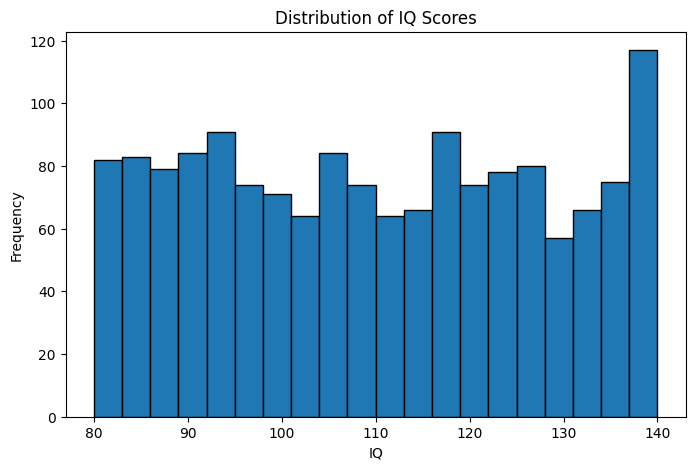

In [412]:
# plotting
plt.figure(figsize=(8,5))
plt.hist(df_employees_clean['iq'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of IQ Scores')
plt.xlabel('IQ')
plt.ylabel('Frequency')
plt.show()

Since the distribution is not strongly skewed and both mean ≈ median,
we can safely fill missing IQ values using either mean or median, in this case mean

In [413]:
# Fill missing value in iq column
df_employees_clean['iq'] = df_employees_clean['iq'].fillna(df_employees_clean['iq'].mean())

In [414]:
df_employees_clean['gtq'].describe()

,gtq
count,1678.000000
mean,27.464839
std,6.286796
min,9.000000
25%,23.000000
50%,27.000000
75%,32.000000
max,46.000000


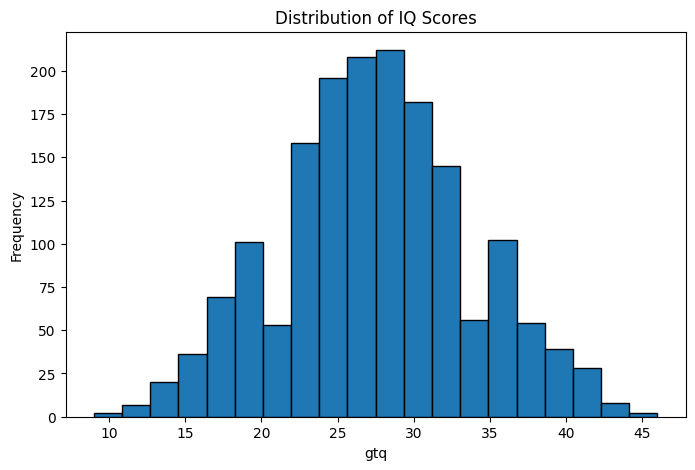

In [415]:
# plotting
plt.figure(figsize=(8,5))
plt.hist(df_employees_clean['gtq'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of IQ Scores')
plt.xlabel('gtq')
plt.ylabel('Frequency')
plt.show()

Since the distribution is normally distributed (bell-shaped). that is, symmetric around the center with no strong skew, we should use the mean to fill missing values

In [416]:
# Fill missing value in iq column
df_employees_clean['gtq'] = df_employees_clean['gtq'].fillna(df_employees_clean['gtq'].mean())

In [417]:
# Impute missing values with "Unknown"
df_employees_clean['mbti'].fillna('Unknown',inplace = True)

In [418]:
df_employees_clean.isna().sum()

,0
employee_id,0
fullname,0
nip,0
years_of_service_months,0
company,0
area,0
position,0
department,0
division,0
directorate,0


all null value has been treated

#### 2.2.5 Duplicated Data

In [419]:
# We can check the duplicate pair by using parameter "keep=False"
df_employees_clean[df_employees_clean.duplicated(keep=False)]

,employee_id,fullname,nip,years_of_service_months,company,area,position,department,division,directorate,grade,education,major,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki


*No duplicated data*

#### 2.2.6 Employees Cleaned Data

In [420]:
# Create a copy after cleaning for other purpose, and its easier if there is something forgoten and needed to be clean later
employees_clean = df_employees_clean.copy()
employees_clean.head()

,employee_id,fullname,nip,years_of_service_months,company,area,position,department,division,directorate,grade,education,major,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki
0,EMP100000,Rendra Pratama,806137.0,64,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business,86.0,75.0,SI,steadiness-influencer,Unknown,94.0,33.0,2
1,EMP100001,Wulan Setiawan,476388.0,16,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design,48.0,52.0,DS,dominant-steadiness,INTP,94.0,17.0,3
2,EMP100002,Julia Jatmiko Situmorang,941921.0,58,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business,66.0,38.0,DC,dominant-conscientious,Unknown,109.0,20.0,3
3,EMP100003,Oka Halim,751615.0,15,PT Aurora Beauty Indonesia,Plant,HRBP,HR,Digital Marketing,Commercial,IV,S1,Psychology,39.0,63.0,SI,steadiness-influencer,ENTJ,85.0,39.0,3
4,EMP100004,Dwi Pratama,443809.0,34,PT Lumo Cosmetics Asia,Store,Supply Planner,Operations,Product Dev,Technology,III,D3,Psychology,75.0,100.0,SC,steadiness-conscientious,INTJ,134.0,21.0,9


In [421]:
# For summary after data cleaning
employees_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              2010 non-null   object 
 1   fullname                 2010 non-null   object 
 2   nip                      2010 non-null   object 
 3   years_of_service_months  2010 non-null   int64  
 4   company                  2010 non-null   object 
 5   area                     2010 non-null   object 
 6   position                 2010 non-null   object 
 7   department               2010 non-null   object 
 8   division                 2010 non-null   object 
 9   directorate              2010 non-null   object 
 10  grade                    2010 non-null   object 
 11  education                2010 non-null   object 
 12  major                    2010 non-null   object 
 13  pauli                    2010 non-null   float64
 14  faxtor                  

In [422]:
# Save to files for inspection and joining
employees_clean.to_csv("profiles_psych.csv", index=False)

print("Created profiles_psych.csv with joined employee table")

Created profiles_psych.csv with joined employee table


### 2.3 Data Cleaning competencies_yearly Table

In [423]:
df_competencies_yearly.head()

,employee_id,score,pillar_code,year,pillar_label
0,EMP100000,2.0,GDR,2021.0,Growth Drive & Resilience
1,EMP100001,NaN,GDR,2021.0,Growth Drive & Resilience
2,EMP100002,1.0,GDR,2021.0,Growth Drive & Resilience
3,EMP100003,NaN,GDR,2021.0,Growth Drive & Resilience
4,EMP100004,3.0,GDR,2021.0,Growth Drive & Resilience


#### 2.3.1 Understanding the Dataset

In [424]:
df_competencies_yearly.shape
print('Number of rows is: ', df_competencies_yearly.shape[0])
print('Number of columns is: ', df_competencies_yearly.shape[1])

Number of rows is:  100500
Number of columns is:  5


In [425]:
df_competencies_yearly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100500 entries, 0 to 100499
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   employee_id   100500 non-null  object 
 1   score         89709 non-null   float64
 2   pillar_code   100500 non-null  object 
 3   year          100500 non-null  float64
 4   pillar_label  100500 non-null  object 
dtypes: float64(2), object(3)
memory usage: 3.8+ MB


In [426]:
df_competencies_yearly.head()

,employee_id,score,pillar_code,year,pillar_label
0,EMP100000,2.0,GDR,2021.0,Growth Drive & Resilience
1,EMP100001,NaN,GDR,2021.0,Growth Drive & Resilience
2,EMP100002,1.0,GDR,2021.0,Growth Drive & Resilience
3,EMP100003,NaN,GDR,2021.0,Growth Drive & Resilience
4,EMP100004,3.0,GDR,2021.0,Growth Drive & Resilience


#### 2.3.2 Convert Data Type

##### a. Convert Data Type in Column `year`

*`year` can be changed into integer.*


In [427]:
# Change id data type into string
df_competencies_yearly['year'] = df_competencies_yearly['year'].astype(int)

In [428]:
#Check the data type of id after converted
df_competencies_yearly.dtypes

,0
employee_id,object
score,float64
pillar_code,object
year,int64
pillar_label,object


#### 2.3.3 Checking for Unique Values and Handle Typo Data

In [429]:
# Check unique data in categorical columns
for column in df_competencies_yearly.select_dtypes(include=['object']).columns:
  num_unique = df_competencies_yearly[column].nunique()
  print(f"Number of unique '{column}' is {num_unique}")

Number of unique 'employee_id' is 2010
Number of unique 'pillar_code' is 10
Number of unique 'pillar_label' is 10


*We will be checking for typos in specific columns of a dataset. The columns we will be checking are:*
* *pillar_code*
* *Cpillar_label*


*The other columns in the dataset are too diverse to check for typos*

*The diverse columns are:*
* *employee_id*

In [430]:
# Count the values
list_obj = ['pillar_code','pillar_label']

for i in list_obj:
    unique_data = df_competencies_yearly[i].value_counts()
    print(unique_data.to_markdown(), '\n\n')

| pillar_code   |   count |
|:--------------|--------:|
| GDR           |   10050 |
| CEX           |   10050 |
| IDS           |   10050 |
| QDD           |   10050 |
| STO           |   10050 |
| SEA           |   10050 |
| VCU           |   10050 |
| LIE           |   10050 |
| FTC           |   10050 |
| CSI           |   10050 | 


| pillar_label                 |   count |
|:-----------------------------|--------:|
| Growth Drive & Resilience    |   10050 |
| Curiosity & Experimentation  |   10050 |
| Insight & Decision Sharpness |   10050 |
| Quality Delivery Discipline  |   10050 |
| Synergy & Team Orientation   |   10050 |
| Social Empathy & Awareness   |   10050 |
| Value Creation for Users     |   10050 |
| Lead, Inspire & Empower      |   10050 |
| Forward Thinking & Clarity   |   10050 |
| Commercial Savvy & Impact    |   10050 | 




*There are no typos in the `Gender`, `Country`, and `Continent` columns because the values are either existing or valid.*




#### 2.3.4 Missing Values

In [431]:
# Number of missing values in each column
df_competencies_yearly.isnull().sum()

,0
employee_id,0
score,10791
pillar_code,0
year,0
pillar_label,0


* *score, 10791 row null*

In [432]:
# Check mean score per year before filling
print("Before filling missing values:")
print(df_competencies_yearly.groupby('year')['score'].mean())
print("\nNumber of missing values before:", df_competencies_yearly['score'].isna().sum())

# Fill missing scores with mean per year
df_competencies_yearly['score'] = df_competencies_yearly.groupby('year')['score'].transform(lambda x: x.fillna(x.mean()))

# Check mean score per year after filling
print("\nAfter filling missing values:")
print(df_competencies_yearly.groupby('year')['score'].mean())
print("\nNumber of missing values after:", df_competencies_yearly['score'].isna().sum())

# Display result
df_competencies_yearly.head()

Before filling missing values:
year
2021    3.286162
2022    3.334053
2023    3.317197
2024    3.309233
2025    3.265099
Name: score, dtype: float64

Number of missing values before: 10791

After filling missing values:
year
2021    3.286162
2022    3.334053
2023    3.317197
2024    3.309233
2025    3.265099
Name: score, dtype: float64

Number of missing values after: 0


,employee_id,score,pillar_code,year,pillar_label
0,EMP100000,2.000000,GDR,2021,Growth Drive & Resilience
1,EMP100001,3.286162,GDR,2021,Growth Drive & Resilience
2,EMP100002,1.000000,GDR,2021,Growth Drive & Resilience
3,EMP100003,3.286162,GDR,2021,Growth Drive & Resilience
4,EMP100004,3.000000,GDR,2021,Growth Drive & Resilience


In [433]:
# Confirm whether null data still exist
df_competencies_yearly.isnull().sum()

,0
employee_id,0
score,0
pillar_code,0
year,0
pillar_label,0


*All null's has been treated*


#### 2.3.5 Duplicated Data

In [434]:
# Check the duplicated
df_competencies_yearly[df_competencies_yearly.duplicated()]

,employee_id,score,pillar_code,year,pillar_label


*No duplicated data*

#### 2.3.6 competencies_yearly Cleaned Data

In [435]:
# Create a copy after cleaning for other purpose, and its easier if there is something forgoten and needed to be clean later
competencies_yearly_clean = df_competencies_yearly.copy()
competencies_yearly_clean.head()

,employee_id,score,pillar_code,year,pillar_label
0,EMP100000,2.000000,GDR,2021,Growth Drive & Resilience
1,EMP100001,3.286162,GDR,2021,Growth Drive & Resilience
2,EMP100002,1.000000,GDR,2021,Growth Drive & Resilience
3,EMP100003,3.286162,GDR,2021,Growth Drive & Resilience
4,EMP100004,3.000000,GDR,2021,Growth Drive & Resilience


In [436]:
# For summary after data cleaning
competencies_yearly_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100500 entries, 0 to 100499
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   employee_id   100500 non-null  object 
 1   score         100500 non-null  float64
 2   pillar_code   100500 non-null  object 
 3   year          100500 non-null  int64  
 4   pillar_label  100500 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 3.8+ MB


#### 2.3.7 Filter competencies_yearly for the latest data (2025) and turned pillar_code into a column

In [437]:
# Try to auto-detect expected columns
col_map = {
    "employee_id": next((c for c in competencies_yearly_clean.columns if c in {"employee_id"}), None),
    "year":        next((c for c in competencies_yearly_clean.columns if c in {"year"}), None),
    "pillar_code": next((c for c in competencies_yearly_clean.columns if c in {"pillar_code"}), None),
    "score":       next((c for c in competencies_yearly_clean.columns if c in {"score"}), None),
}

missing = [k for k,v in col_map.items() if v is None]
if missing:
    raise ValueError(f"Cannot find required columns in competencies_yearly: {missing}. "
                     f"Available: {list(competencies_yearly_clean.columns)}")

emp_col, year_col, pillar_col, score_col = col_map["employee_id"], col_map["year"], col_map["pillar_code"], col_map["score"]

In [438]:
# Clean values
competencies_yearly_clean[pillar_col] = competencies_yearly_clean[pillar_col].astype(str).str.strip().str.upper()
# ensure year is numeric for sorting
competencies_yearly_clean[year_col] = pd.to_numeric(competencies_yearly_clean[year_col], errors="coerce")
# keep only rows with known year and score
competencies_yearly_clean = competencies_yearly_clean.dropna(subset=[year_col, score_col])

In [439]:
# Keep latest year per employee × pillar
competencies_yearly_sorted = competencies_yearly_clean.sort_values([emp_col, pillar_col, year_col], ascending=[True, True, False])
competencies_yearly_latest = competencies_yearly_sorted.drop_duplicates(subset=[emp_col, pillar_col], keep="first")

In [440]:
# Pivot to wide columns: one column per pillar code
competencies_wide = competencies_yearly_latest.pivot(index=emp_col, columns=pillar_col, values=score_col)

In [441]:
# prefix column names for clarity
competencies_wide.columns = [f" score_comp_{c}" for c in competencies_wide.columns]

competencies_wide = competencies_wide.reset_index()

In [442]:
competencies_wide.head()

,employee_id,score_comp_CEX,score_comp_CSI,score_comp_FTC,score_comp_GDR,score_comp_IDS,score_comp_LIE,score_comp_QDD,score_comp_SEA,score_comp_STO,score_comp_VCU
0,DUP1942,4.0,5.0,5.0,5.0,5.0,3.265099,5.0,5.0,5.000000,5.0
1,DUP2096,3.0,3.0,2.0,3.0,4.0,3.000000,2.0,3.0,3.000000,3.0
2,DUP2722,3.0,5.0,5.0,5.0,4.0,5.000000,3.0,4.0,3.265099,5.0
3,DUP3015,2.0,3.0,3.0,3.0,4.0,3.000000,3.0,3.0,4.000000,3.0
4,DUP3452,3.0,2.0,2.0,3.0,3.0,3.000000,4.0,4.0,3.000000,4.0


In [443]:
# Save outputs to inspect
competencies_wide.to_csv("competencies_latest_pivot.csv", index=False)

In [444]:
competencies_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   employee_id      2010 non-null   object 
 1    score_comp_CEX  2010 non-null   float64
 2    score_comp_CSI  2010 non-null   float64
 3    score_comp_FTC  2010 non-null   float64
 4    score_comp_GDR  2010 non-null   float64
 5    score_comp_IDS  2010 non-null   float64
 6    score_comp_LIE  2010 non-null   float64
 7    score_comp_QDD  2010 non-null   float64
 8    score_comp_SEA  2010 non-null   float64
 9    score_comp_STO  2010 non-null   float64
 10   score_comp_VCU  2010 non-null   float64
dtypes: float64(10), object(1)
memory usage: 172.9+ KB


### 2.4 df_performance_yearly

#### 2.4.1 Understanding the Dataset

In [445]:
# Make a copy for data cleaning
df_performance_yearly_clean = df_performance_yearly.copy()

In [446]:
df_performance_yearly_clean.shape
print('Number of rows is: ', df_performance_yearly_clean.shape[0])
print('Number of columns is: ', df_performance_yearly_clean.shape[1])

Number of rows is:  10050
Number of columns is:  3


In [447]:
df_performance_yearly_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10050 entries, 0 to 10049
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  10050 non-null  object 
 1   rating       8942 non-null   float64
 2   year         10050 non-null  float64
dtypes: float64(2), object(1)
memory usage: 314.1+ KB


In [448]:
df_performance_yearly_clean.head()

,employee_id,rating,year
0,EMP100000,2.0,2021.0
1,EMP100001,NaN,2021.0
2,EMP100002,2.0,2021.0
3,EMP100003,NaN,2021.0
4,EMP100004,3.0,2021.0


#### 2.4.2 Convert Data Type

##### a. Convert Data Type in Column `year`

In [449]:
# Change id data type into string
df_performance_yearly_clean['year'] =df_performance_yearly_clean['year'].astype(int)

In [450]:
#Check the data type of id after converted
df_performance_yearly_clean.dtypes

,0
employee_id,object
rating,float64
year,int64


#### 2.4.3 Checking for Unique Values and Handle Typo Data

In [451]:
# Check unique data in categorical columns
for column in df_performance_yearly_clean.select_dtypes(include=['object']).columns:
  num_unique = df_performance_yearly_clean[column].nunique()
  print(f"Number of unique '{column}' is {num_unique}")

Number of unique 'employee_id' is 2010


*We will not be checking for typos in specific columns of a dataset beacuse the employee_id are too diverse to check for typos*

#### 2.4.4 Missing Values

In [452]:
# Number of missing values in each column
df_performance_yearly_clean.isnull().sum()

,0
employee_id,0
rating,1108
year,0


In [453]:
#percentage of missing values of each column
round(df_performance_yearly_clean.isnull().sum()/len(df_performance_yearly_clean)*100,2)

,0
employee_id,0.00
rating,11.02
year,0.00


*There are 1108 rows missing values detected in rating column*

In [454]:
# Check mean score per year before filling
print("Before filling missing values:")
print(df_performance_yearly_clean.groupby('year')['rating'].mean())
print("\nNumber of missing values before:", df_performance_yearly_clean['rating'].isna().sum())

# Fill missing scores with mean per year
df_performance_yearly_clean['rating'] = df_performance_yearly_clean.groupby('year')['rating'].transform(lambda x: x.fillna(x.mean()))

# Check mean score per year after filling
print("\nAfter filling missing values:")
print(df_performance_yearly_clean.groupby('year')['rating'].mean())
print("\nNumber of missing values after:", df_performance_yearly_clean['rating'].isna().sum())

# Display result
df_performance_yearly_clean.head()

Before filling missing values:
year
2021    3.225370
2022    3.271114
2023    3.208065
2024    3.285181
2025    3.093088
Name: rating, dtype: float64

Number of missing values before: 1108

After filling missing values:
year
2021    3.225370
2022    3.271114
2023    3.208065
2024    3.285181
2025    3.093088
Name: rating, dtype: float64

Number of missing values after: 0


,employee_id,rating,year
0,EMP100000,2.00000,2021
1,EMP100001,3.22537,2021
2,EMP100002,2.00000,2021
3,EMP100003,3.22537,2021
4,EMP100004,3.00000,2021


#### 2.4.5 Duplicated Data

In [455]:
# Check the duplicated
df_performance_yearly_clean[df_performance_yearly_clean.duplicated()]

,employee_id,rating,year


*No duplicated data*

#### 2.4.6 Performance-yearly Cleaned Data

In [456]:
# Create a copy after cleaning for other purpose, and its easier if there is something forgoten and needed to be clean later
performance_yearly_clean = df_performance_yearly_clean.copy()
performance_yearly_clean.head()

,employee_id,rating,year
0,EMP100000,2.00000,2021
1,EMP100001,3.22537,2021
2,EMP100002,2.00000,2021
3,EMP100003,3.22537,2021
4,EMP100004,3.00000,2021


In [457]:
# For summary after data cleaning
performance_yearly_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10050 entries, 0 to 10049
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  10050 non-null  object 
 1   rating       10050 non-null  float64
 2   year         10050 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 314.1+ KB


#### 2.4.7 Filter performance_yearly Data from 2025 as the latest data

Create the High Performer Flag with rules

 High performer flag: is_top = 1 if rating == 5 else 0.

In [458]:
# Create high performance flag
performance_yearly_clean['is_top'] = performance_yearly_clean['rating'].apply(lambda x: 1 if x == 5 else 0)

In [459]:
# keep only the latest per employee
if 'year' in performance_yearly_clean.columns:
   performance_yearly_clean = performance_yearly_clean.sort_values(['employee_id', 'year'], ascending=[True, False]) \
               .drop_duplicates('employee_id', keep='first')

In [460]:
# Check the distribution of the new flag
print(performance_yearly_clean['is_top'].value_counts())

is_top
0    1842
1     168
Name: count, dtype: int64


In [461]:
# Save to verify
performance_yearly_clean.to_csv("performance_yearly_with_is_top.csv", index=False)
print("Added 'is_top' column and saved to performance_yearly_with_is_top.csv")

Added 'is_top' column and saved to performance_yearly_with_is_top.csv


In [462]:
performance_yearly_clean.head()

,employee_id,rating,year,is_top
10045,DUP1942,5.0,2025,1
10046,DUP2096,3.0,2025,0
10043,DUP2722,4.0,2025,0
10044,DUP3015,3.0,2025,0
10049,DUP3452,3.0,2025,0


### 2.5 Data Cleaning papi_scores Table

#### 2.4.1 Understanding the Dataset

In [463]:
df_papi_scores.shape
print('Number of rows is: ', df_papi_scores.shape[0])
print('Number of columns is: ', df_papi_scores.shape[1])

Number of rows is:  40200
Number of columns is:  3


In [464]:
df_papi_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40200 entries, 0 to 40199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  40200 non-null  object 
 1   scale_code   40200 non-null  object 
 2   score        36997 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [465]:
df_papi_scores.head()

,employee_id,scale_code,score
0,EMP100000,Papi_N,2.0
1,EMP100001,Papi_N,8.0
2,EMP100002,Papi_N,9.0
3,EMP100003,Papi_N,9.0
4,EMP100004,Papi_N,7.0


#### 2.5.2 Convert Data Type

In [466]:
# Check the data type of df_papi_scores
df_papi_scores.dtypes

,0
employee_id,object
scale_code,object
score,float64


All data types are already correct

#### 2.5.3 Checking for Unique Values and Handle Typo Data

In [467]:
# Check unique data in categorical columns
for column in df_papi_scores.select_dtypes(include=['object']).columns:
  num_unique = df_papi_scores[column].nunique()
  print(f"Number of unique '{column}' is {num_unique}")

Number of unique 'employee_id' is 2010
Number of unique 'scale_code' is 20


*We will be checking for typos in specific columns of a dataset. The columns we will be checking are:*
* *scale_code*

*The other columns in the dataset are too diverse to check for typos*

*The diverse columns are:*
* *employee_id*

In [468]:
# Count the values
list_obj = ['scale_code']

for i in list_obj:
    unique_data = df_papi_scores[i].value_counts()
    print(unique_data.to_markdown(), '\n\n')

| scale_code   |   count |
|:-------------|--------:|
| Papi_N       |    2010 |
| Papi_G       |    2010 |
| Papi_A       |    2010 |
| Papi_L       |    2010 |
| Papi_P       |    2010 |
| Papi_I       |    2010 |
| Papi_T       |    2010 |
| Papi_V       |    2010 |
| Papi_X       |    2010 |
| Papi_S       |    2010 |
| Papi_B       |    2010 |
| Papi_O       |    2010 |
| Papi_R       |    2010 |
| Papi_D       |    2010 |
| Papi_C       |    2010 |
| Papi_Z       |    2010 |
| Papi_E       |    2010 |
| Papi_K       |    2010 |
| Papi_F       |    2010 |
| Papi_W       |    2010 | 




*There are no typos in the `scale_code` columns because the values are either existing or valid.*

#### 2.5.4 Missing Values

In [469]:
# Number of missing values in each column
df_papi_scores.isnull().sum()

,0
employee_id,0
scale_code,0
score,3203


In [470]:
#percentage of missing values of each column
round(df_papi_scores.isnull().sum()/len(df_papi_scores)*100,2)

,0
employee_id,0.00
scale_code,0.00
score,7.97


* *`score`, 3203 row null which is 7.97% of the total data and we will fill it*

##### Handle Missing Values in Column `score`

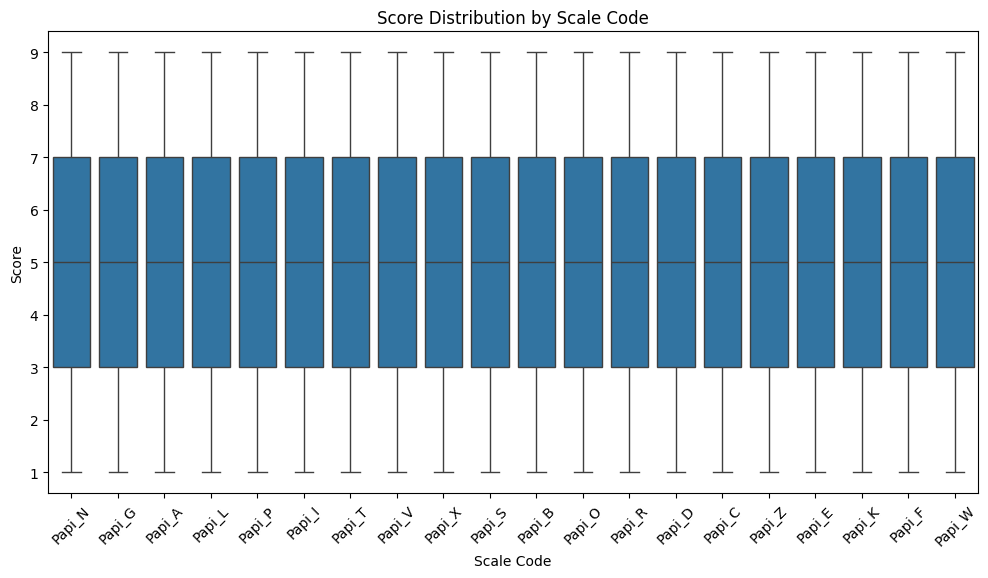

In [471]:
# plotting
plt.figure(figsize=(12,6))
sns.boxplot(data=df_papi_scores, x='scale_code', y='score')
plt.title('Score Distribution by Scale Code')
plt.xlabel('Scale Code')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

Since there's no outlier we will fill it with mean per papi cetegory, for example papi_N score missing value will be filled with average (mean) score of papi_N score

In [472]:
# Check mean score per scale_code before filling
print("Before filling missing values:")
print(df_papi_scores.groupby('scale_code')['score'].mean())
print("\nNumber of missing values before:", df_papi_scores['score'].isna().sum())

# Fill missing scores with mean per scale_code
df_papi_scores['score'] = df_papi_scores.groupby('scale_code')['score'].transform(lambda x: x.fillna(x.mean()))

# Check mean score per scale_code after filling
print("\nAfter filling missing values:")
print(df_papi_scores.groupby('scale_code')['score'].mean())
print("\nNumber of missing values after:", df_papi_scores['score'].isna().sum())

# Display result
df_papi_scores.head()

Before filling missing values:
scale_code
Papi_A    5.030711
Papi_B    4.918202
Papi_C    4.860590
Papi_D    4.977814
Papi_E    5.065916
Papi_F    5.057158
Papi_G    4.931536
Papi_I    5.036314
Papi_K    5.015847
Papi_L    5.099836
Papi_N    5.092772
Papi_O    4.892916
Papi_P    4.996812
Papi_R    5.026344
Papi_S    4.994586
Papi_T    4.953514
Papi_V    4.905609
Papi_W    4.986964
Papi_X    5.020945
Papi_Z    4.976152
Name: score, dtype: float64

Number of missing values before: 3203

After filling missing values:
scale_code
Papi_A    5.030711
Papi_B    4.918202
Papi_C    4.860590
Papi_D    4.977814
Papi_E    5.065916
Papi_F    5.057158
Papi_G    4.931536
Papi_I    5.036314
Papi_K    5.015847
Papi_L    5.099836
Papi_N    5.092772
Papi_O    4.892916
Papi_P    4.996812
Papi_R    5.026344
Papi_S    4.994586
Papi_T    4.953514
Papi_V    4.905609
Papi_W    4.986964
Papi_X    5.020945
Papi_Z    4.976152
Name: score, dtype: float64

Number of missing values after: 0


,employee_id,scale_code,score
0,EMP100000,Papi_N,2.0
1,EMP100001,Papi_N,8.0
2,EMP100002,Papi_N,9.0
3,EMP100003,Papi_N,9.0
4,EMP100004,Papi_N,7.0


*All null's has been treated*


#### 2.5.5 Duplicated Data

In [473]:
# Check the duplicated
df_papi_scores[df_papi_scores.duplicated()]

,employee_id,scale_code,score


*No duplicated data*

#### 2.5.6 papi_scores Cleaned Data

In [474]:
# Create a copy after cleaning for other purpose, and its easier if there is something forgoten and needed to be clean later
papi_scores_clean = df_papi_scores.copy()
papi_scores_clean.head()

,employee_id,scale_code,score
0,EMP100000,Papi_N,2.0
1,EMP100001,Papi_N,8.0
2,EMP100002,Papi_N,9.0
3,EMP100003,Papi_N,9.0
4,EMP100004,Papi_N,7.0


In [475]:
# For summary after data cleaning
papi_scores_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40200 entries, 0 to 40199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  40200 non-null  object 
 1   scale_code   40200 non-null  object 
 2   score        40200 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


#### 2.5.7 Turned Papi scale_code into a column

In [476]:
# Auto-detect key columns
col_map = {
    "employee_id": next((c for c in papi_scores_clean.columns if c in {"employee_id","employee id","id"}), None),
    "scale_code":  next((c for c in papi_scores_clean.columns if c in {"scale_code","scalecode","code","scale"}), None),
    "score":       next((c for c in papi_scores_clean.columns if c in {"score","value","rating","papi_score"}), None),
}

missing = [k for k,v in col_map.items() if v is None and k in {"employee_id","scale_code","score"}]
if missing:
    raise ValueError(f"Cannot find required columns in papi_scores: {missing}. "
                     f"Available: {list(papi_scores_clean.columns)}")

emp_col   = col_map["employee_id"]
code_col  = col_map["scale_code"]
score_col = col_map["score"]

In [477]:
# Clean values
papi_scores_clean[code_col] = papi_scores_clean[code_col].astype(str).str.strip().str.upper()
papi_scores_clean[score_col] = pd.to_numeric(papi_scores_clean[score_col], errors="coerce")

In [478]:
# drop rows without score or code
papi_scores_clean = papi_scores_clean.dropna(subset=[code_col, score_col])

In [479]:
# Pivot wide to one column per PAPI scale code
papi_wide = papi_scores_clean.pivot(index=emp_col, columns=code_col, values=score_col)

In [480]:
# Prefix for clarity
papi_wide.columns = [f"score_{c}" for c in papi_wide.columns]
papi_wide = papi_wide.reset_index()

In [481]:
papi_wide.head()

,employee_id,score_PAPI_A,score_PAPI_B,score_PAPI_C,score_PAPI_D,score_PAPI_E,score_PAPI_F,score_PAPI_G,score_PAPI_I,score_PAPI_K,score_PAPI_L,score_PAPI_N,score_PAPI_O,score_PAPI_P,score_PAPI_R,score_PAPI_S,score_PAPI_T,score_PAPI_V,score_PAPI_W,score_PAPI_X,score_PAPI_Z
0,DUP1942,6.0,4.918202,1.0,4.0,3.0,5.0,4.000000,1.0,3.0,6.0,5.092772,3.000000,5.000000,7.0,9.0,9.000000,1.000000,8.0,3.0,4.976152
1,DUP2096,1.0,6.000000,9.0,3.0,4.0,1.0,2.000000,6.0,9.0,3.0,1.000000,4.000000,4.000000,6.0,8.0,2.000000,6.000000,3.0,8.0,2.000000
2,DUP2722,2.0,4.918202,6.0,4.0,1.0,4.0,9.000000,9.0,1.0,3.0,8.000000,2.000000,4.996812,6.0,1.0,7.000000,3.000000,6.0,3.0,3.000000
3,DUP3015,5.0,4.000000,3.0,4.0,9.0,2.0,8.000000,9.0,1.0,7.0,5.000000,1.000000,8.000000,7.0,3.0,4.953514,4.905609,3.0,5.0,3.000000
4,DUP3452,7.0,9.000000,1.0,9.0,7.0,3.0,4.931536,2.0,1.0,4.0,5.092772,4.892916,4.000000,2.0,9.0,4.953514,9.000000,1.0,6.0,4.000000


In [482]:
# Save to files for inspection and joining
papi_wide.to_csv("papi_latest_pivot.csv", index=False)

print("Created papi_latest_pivot.csv with columns like papi_D, papi_N, ...")

Created papi_latest_pivot.csv with columns like papi_D, papi_N, ...


In [483]:
papi_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employee_id   2010 non-null   object 
 1   score_PAPI_A  2010 non-null   float64
 2   score_PAPI_B  2010 non-null   float64
 3   score_PAPI_C  2010 non-null   float64
 4   score_PAPI_D  2010 non-null   float64
 5   score_PAPI_E  2010 non-null   float64
 6   score_PAPI_F  2010 non-null   float64
 7   score_PAPI_G  2010 non-null   float64
 8   score_PAPI_I  2010 non-null   float64
 9   score_PAPI_K  2010 non-null   float64
 10  score_PAPI_L  2010 non-null   float64
 11  score_PAPI_N  2010 non-null   float64
 12  score_PAPI_O  2010 non-null   float64
 13  score_PAPI_P  2010 non-null   float64
 14  score_PAPI_R  2010 non-null   float64
 15  score_PAPI_S  2010 non-null   float64
 16  score_PAPI_T  2010 non-null   float64
 17  score_PAPI_V  2010 non-null   float64
 18  score_PAPI_W  2010 non-null 

### 2.6 Data Cleaning strengths table

#### 2.6.1 Understanding the Dataset

In [484]:
df_strengths.shape
print('Number of rows is: ', df_strengths.shape[0])
print('Number of columns is: ', df_strengths.shape[1])

Number of rows is:  28140
Number of columns is:  3


In [485]:
df_strengths.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28140 entries, 0 to 28139
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  28140 non-null  object 
 1   rank         28140 non-null  float64
 2   theme        25911 non-null  object 
dtypes: float64(1), object(2)
memory usage: 879.4+ KB


In [486]:
df_strengths.head()

,employee_id,rank,theme
0,EMP100000,1.0,NaN
1,EMP100001,1.0,Responsibility
2,EMP100002,1.0,Restorative
3,EMP100003,1.0,Belief
4,EMP100004,1.0,Deliberative


#### 2.6.2 Convert Data Type

##### Convert Data Type in Column `rank`

*`rank` will be change into integer.*


In [487]:
# Change Srank data type into integer
df_strengths['rank'] = df_strengths['rank'].astype(int)

In [488]:
# Check the data type of rank after converted
df_strengths.dtypes

,0
employee_id,object
rank,int64
theme,object


#### 2.6.3 Checking for Unique Values and Handle Typo Data

In [489]:
# Check unique data in categorical columns
for column in df_strengths.select_dtypes(include=['object']).columns:
  num_unique = df_strengths[column].nunique()
  print(f"Number of unique '{column}' is {num_unique}")

Number of unique 'employee_id' is 2010
Number of unique 'theme' is 34


*We will be checking for typos in specific columns of a dataset. The columns we will be checking are:*
* *theme*

In [490]:
# Count the values
list_obj = ['theme']

for i in list_obj:
    unique_data = df_strengths[i].value_counts()
    print(unique_data.to_markdown(), '\n\n')

| theme             |   count |
|:------------------|--------:|
| Belief            |     811 |
| Self-Assurance    |     808 |
| Achiever          |     792 |
| Input             |     782 |
| Deliberative      |     780 |
| Positivity        |     780 |
| Restorative       |     776 |
| Context           |     774 |
| Futuristic        |     774 |
| Intellection      |     774 |
| Empathy           |     773 |
| Arranger          |     771 |
| Communication     |     766 |
| Relator           |     764 |
| Learner           |     763 |
| Focus             |     762 |
| Activator         |     762 |
| Ideation          |     761 |
| Significance      |     759 |
| Individualization |     758 |
| Competition       |     758 |
| Discipline        |     755 |
| Woo               |     755 |
| Analytical        |     752 |
| Command           |     750 |
| Adaptability      |     747 |
| Consistency       |     747 |
| Maximizer         |     745 |
| Connectedness     |     743 |
| Respon

*There are no typos in the `theme` columns because the values are either existing or valid.*




#### 2.6.4 Missing Values

In [491]:
# Number of missing values in each column
df_strengths.isnull().sum()

,0
employee_id,0
rank,0
theme,2229


In [492]:
# percentage of missing values of each column
round(df_strengths.isnull().sum()/len(df_strengths)*100,2)

,0
employee_id,0.00
rank,0.00
theme,7.92


*There are 2229 missing values detected on theme column*

In [493]:
df_strengths.loc[df_strengths['theme'].isnull()]

,employee_id,rank,theme
0,EMP100000,1,NaN
8,EMP100008,1,NaN
13,EMP100013,1,NaN
50,EMP100050,1,NaN
52,EMP100052,1,NaN
...,...,...,...
28049,EMP101919,14,NaN
28060,EMP101930,14,NaN
28084,EMP101954,14,NaN
28085,EMP101955,14,NaN


In [494]:
# Impute missing values with "Unknown"
df_strengths['theme'].fillna('Unknown',inplace = True)

In [495]:
df_strengths.loc[df_strengths['theme']=='Unknown']

,employee_id,rank,theme
0,EMP100000,1,Unknown
8,EMP100008,1,Unknown
13,EMP100013,1,Unknown
50,EMP100050,1,Unknown
52,EMP100052,1,Unknown
...,...,...,...
28049,EMP101919,14,Unknown
28060,EMP101930,14,Unknown
28084,EMP101954,14,Unknown
28085,EMP101955,14,Unknown


In [496]:
# Confirm whether null data still exist
df_strengths.isnull().sum()

,0
employee_id,0
rank,0
theme,0


*All null's has been treated*

#### 2.6.5 Duplicated Data

In [497]:
# Check the duplicated
df_strengths[df_strengths.duplicated()]

,employee_id,rank,theme


*No duplicated data*

#### 2.6.6 Strengths Cleaned Data

In [498]:
# Create a copy after cleaning for other purpose, and its easier if there is something forgoten and needed to be clean later
strengths_clean = df_strengths.copy()
strengths_clean.head()

,employee_id,rank,theme
0,EMP100000,1,Unknown
1,EMP100001,1,Responsibility
2,EMP100002,1,Restorative
3,EMP100003,1,Belief
4,EMP100004,1,Deliberative


In [499]:
# For summary after data cleaning
strengths_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28140 entries, 0 to 28139
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   employee_id  28140 non-null  object
 1   rank         28140 non-null  int64 
 2   theme        28140 non-null  object
dtypes: int64(1), object(2)
memory usage: 879.4+ KB


#### 2.6.7 Turned Strengths rank into a column

In [500]:
# Auto-detect key columns
col_map = {
    "employee_id": next((c for c in strengths_clean.columns if c in {"employee_id","employee id","id"}), None),
    "rank":        next((c for c in strengths_clean.columns if c in {"rank","order","position","seq"}), None),
    "theme":       next((c for c in strengths_clean.columns if c in {"theme","strength","strength_theme","name"}), None),
}

missing = [k for k,v in col_map.items() if v is None and k in {"employee_id","rank","theme"}]
if missing:
    raise ValueError(f"Cannot find required columns in strengths: {missing}. "
                     f"Available: {list(strengths_clean.columns)}")

emp_col   = col_map["employee_id"]
rank_col  = col_map["rank"]
theme_col = col_map["theme"]

In [501]:
# Clean values
strengths_clean[theme_col] = strengths_clean[theme_col].astype(str).str.strip()
strengths_clean[rank_col]  = pd.to_numeric(strengths_clean[rank_col], errors="coerce")

In [502]:
# Drop rows missing essentials
need_cols = [emp_col, theme_col, rank_col]
strengths_clean = strengths_clean.dropna(subset=[emp_col, theme_col, rank_col])

In [503]:
# keep the best (lowest) rank per employee × theme, then one row per employee × rank
strengths_clean = (strengths_clean
         .sort_values([emp_col, theme_col, rank_col], ascending=[True, True, True])
         .drop_duplicates(subset=[emp_col, theme_col], keep="first")
         .sort_values([emp_col, rank_col], ascending=[True, True])
         .drop_duplicates(subset=[emp_col, rank_col], keep="first"))

In [504]:
# Limit to top K ranks beacuse we only need top 5
TOP_K = 5
strengths_clean = strengths_clean[strengths_clean[rank_col] <= TOP_K]

In [505]:
# Pivot wide: one column per rank with the theme as value
strengths_wide = strengths_clean.pivot(index=emp_col, columns=rank_col, values=theme_col)

In [506]:
# Build consistent column names like strength_rank_1 ... strength_rank_K
# Ensure ranks 1..TOP_K exist as columns even if missing for some employees
for r in range(1, TOP_K+1):
    if r not in strengths_wide.columns:
        strengths_wide[r] = pd.NA
strengths_wide = strengths_wide[sorted(strengths_wide.columns)]  # order by rank
strengths_wide.columns = [f"strength_rank_{int(c)}" for c in strengths_wide.columns]
strengths_wide = strengths_wide.reset_index()

In [507]:
strengths_wide.tail()

,employee_id,strength_rank_1,strength_rank_2,strength_rank_3,strength_rank_4,strength_rank_5
2005,EMP101995,Belief,Relator,Unknown,Consistency,Context
2006,EMP101996,Positivity,Achiever,Woo,Restorative,Maximizer
2007,EMP101997,Positivity,Unknown,Empathy,Restorative,Relator
2008,EMP101998,Achiever,Command,Connectedness,Activator,Self-Assurance
2009,EMP101999,Ideation,Input,Positivity,Adaptability,Connectedness


In [508]:
# Save outputs
strengths_wide.to_csv("strengths.csv", index=False)

print("strengths.csv created with columns strength_rank_1 ... strength_rank_")

strengths.csv created with columns strength_rank_1 ... strength_rank_


### 2.7 Merge sll the table


In [138]:
# Standardize key name
key = "employee_id"
for df in [employees_clean, performance_yearly_clean, competencies_wide, papi_wide, strengths_wide]:
    if key not in df.columns:
        candidates = [c for c in df.columns if "id" in c]
        if candidates:
            df.rename(columns={candidates[0]: key}, inplace=True)

In [139]:
# Perform successive left joins
df_model = (
    employees_clean
    .merge(performance_yearly_clean, on=key, how="left", suffixes=("", "_perf"))
    .merge(competencies_wide, on=key, how="left")
    .merge(papi_wide, on=key, how="left")
    .merge(strengths_wide, on=key, how="left")
)

In [140]:
# Quick sanity check
df_model.head(3)

,employee_id,fullname,nip,years_of_service_months,company,area,position,department,division,directorate,grade,education,major,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,year,is_top,score_comp_CEX,score_comp_CSI,score_comp_FTC,score_comp_GDR,score_comp_IDS,score_comp_LIE,score_comp_QDD,score_comp_SEA,score_comp_STO,score_comp_VCU,score_PAPI_A,score_PAPI_B,score_PAPI_C,score_PAPI_D,score_PAPI_E,score_PAPI_F,score_PAPI_G,score_PAPI_I,score_PAPI_K,score_PAPI_L,score_PAPI_N,score_PAPI_O,score_PAPI_P,score_PAPI_R,score_PAPI_S,score_PAPI_T,score_PAPI_V,score_PAPI_W,score_PAPI_X,score_PAPI_Z,strength_rank_1,strength_rank_2,strength_rank_3,strength_rank_4,strength_rank_5
0,EMP100000,Rendra Pratama,806137.0,64,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business,86.0,75.0,SI,steadiness-influencer,Unknown,94.0,33.0,2,3.0,2025,0,3.0,3.0,4.000000,3.0,4.0,3.0,3.0,2.000000,3.0,4.0,1.0,6.000000,5.0,4.977814,1.0,3.0,5.0,8.0,5.015847,7.000000,2.0,9.0,3.0,7.0,9.0,3.0,4.0,4.0,2.0,1.0,Unknown,Adaptability,Context,Competition,Activator
1,EMP100001,Wulan Setiawan,476388.0,16,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design,48.0,52.0,DS,dominant-steadiness,INTP,94.0,17.0,3,3.0,2025,0,2.0,3.0,3.000000,2.0,3.0,2.0,2.0,3.265099,2.0,3.0,3.0,1.000000,7.0,4.000000,2.0,2.0,2.0,4.0,6.000000,7.000000,8.0,9.0,5.0,3.0,3.0,6.0,7.0,1.0,6.0,9.0,Responsibility,Includer,Significance,Context,Adaptability
2,EMP100002,Julia Jatmiko Situmorang,941921.0,58,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business,66.0,38.0,DC,dominant-conscientious,Unknown,109.0,20.0,3,4.0,2025,0,5.0,3.0,3.265099,3.0,3.0,3.0,5.0,3.000000,4.0,4.0,2.0,4.918202,4.0,2.000000,5.0,7.0,2.0,8.0,4.000000,5.099836,9.0,5.0,3.0,1.0,3.0,9.0,9.0,1.0,4.0,6.0,Restorative,Maximizer,Woo,Includer,Command


In [141]:
# Save the file
df_model.to_csv("df_model_full.csv", index=False)
print("Saved merged dataset to df_model_full.csv")

Saved merged dataset to df_model_full.csv


## 3. Exploratory Data Analysis

In [142]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              2010 non-null   object 
 1   fullname                 2010 non-null   object 
 2   nip                      2010 non-null   object 
 3   years_of_service_months  2010 non-null   int64  
 4   company                  2010 non-null   object 
 5   area                     2010 non-null   object 
 6   position                 2010 non-null   object 
 7   department               2010 non-null   object 
 8   division                 2010 non-null   object 
 9   directorate              2010 non-null   object 
 10  grade                    2010 non-null   object 
 11  education                2010 non-null   object 
 12  major                    2010 non-null   object 
 13  pauli                    2010 non-null   float64
 14  faxtor                  

In [143]:
df_model.shape
print('Number of rows is: ', df_model.shape[0])
print('Number of columns is: ', df_model.shape[1])

Number of rows is:  2010
Number of columns is:  59


### 3.1 Descriptive Statistics

#### 3.1.1 Numerical Variables

In [144]:
numerical = df_model.select_dtypes(include = ['number'])

desc_num = numerical.describe()
desc_num.loc['kurtosis'] = numerical.kurt() # Show kurtosis statistic
desc_num.loc['skewness'] = numerical.skew() # Show Skewness statistic
desc_num.loc['variance'] = numerical.var() # Show variance statistic
desc_num.round(2)

,years_of_service_months,pauli,faxtor,iq,gtq,tiki,rating,year,is_top,score_comp_CEX,score_comp_CSI,score_comp_FTC,score_comp_GDR,score_comp_IDS,score_comp_LIE,score_comp_QDD,score_comp_SEA,score_comp_STO,score_comp_VCU,score_PAPI_A,score_PAPI_B,score_PAPI_C,score_PAPI_D,score_PAPI_E,score_PAPI_F,score_PAPI_G,score_PAPI_I,score_PAPI_K,score_PAPI_L,score_PAPI_N,score_PAPI_O,score_PAPI_P,score_PAPI_R,score_PAPI_S,score_PAPI_T,score_PAPI_V,score_PAPI_W,score_PAPI_X,score_PAPI_Z
count,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.0,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00,2010.00
mean,50.12,59.97,60.28,109.51,27.46,5.48,3.09,2025.0,0.08,3.11,3.38,3.28,3.25,3.26,3.30,3.29,3.13,3.32,3.34,5.03,4.92,4.86,4.98,5.07,5.06,4.93,5.04,5.02,5.10,5.09,4.89,5.00,5.03,4.99,4.95,4.91,4.99,5.02,4.98
std,25.18,23.43,22.93,15.73,5.74,2.89,1.03,0.0,0.28,2.43,5.35,4.42,4.42,4.42,4.42,4.42,2.43,4.91,4.91,2.45,2.51,2.45,2.53,2.52,2.46,2.47,2.50,2.49,2.51,2.46,2.42,2.53,2.46,2.50,2.48,2.47,2.51,2.49,2.46
min,0.00,20.00,20.00,80.00,9.00,1.00,0.00,2025.0,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,32.00,39.00,41.00,98.00,24.00,3.00,3.00,2025.0,0.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00
50%,50.00,60.00,62.00,109.51,27.46,6.00,3.00,2025.0,0.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,5.00,4.92,5.00,5.00,5.07,5.06,4.93,5.04,5.00,5.10,5.09,4.89,5.00,5.00,5.00,5.00,4.91,5.00,5.00,5.00
75%,66.00,80.00,80.00,120.00,31.00,8.00,4.00,2025.0,0.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00
max,149.00,100.00,100.00,140.00,46.00,10.00,6.00,2025.0,1.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00
kurtosis,-0.16,-1.21,-1.15,-0.70,0.28,-1.23,-0.22,0.0,7.08,1204.83,301.58,435.07,436.55,435.34,437.05,434.15,1215.19,357.31,356.49,-1.04,-1.13,-1.02,-1.11,-1.12,-1.07,-1.10,-1.11,-1.07,-1.08,-1.06,-1.00,-1.14,-1.10,-1.09,-1.08,-1.07,-1.08,-1.10,-1.06
skewness,0.30,0.00,-0.06,0.06,0.04,-0.01,-0.16,0.0,3.01,30.54,17.01,20.19,20.24,20.20,20.26,20.16,30.73,18.44,18.41,0.02,0.03,0.04,0.00,-0.04,-0.04,0.04,-0.02,-0.01,-0.06,-0.03,0.08,-0.00,0.02,0.01,0.05,0.04,0.01,-0.03,0.01


#### 3.1.2 Categorical Variables

In [145]:
categorical = df_model.select_dtypes(exclude=['number'])
categorical.describe()

,employee_id,fullname,nip,company,area,position,department,division,directorate,grade,education,major,disc,disc_word,mbti,strength_rank_1,strength_rank_2,strength_rank_3,strength_rank_4,strength_rank_5
count,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2000,1987,1975,1969
unique,2010,2010,1996,4,4,6,6,5,3,3,4,6,12,12,17,35,35,35,35,35
top,DUP3452,Fitri Anugrah Subekti,149080.0,PT VASKA Wellness,Distribution,HRBP,IT,Talent Management,Technology,III,S2,Economics,CI,conscientious-influencer,ENFP,Unknown,Unknown,Unknown,Unknown,Unknown
freq,1,1,2,532,542,361,364,413,703,676,526,368,188,188,150,140,167,131,142,113


### 3.2 Distribution of Employee by Rating 5

*How many employee has 5 star?*

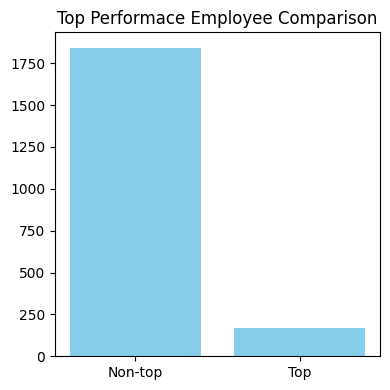

In [146]:
vc = df_model['is_top'].value_counts().sort_index()
plt.figure(figsize=(4,4)); plt.bar(['Non-top','Top'], vc.values, color='skyblue'); plt.title('Top Performace Employee Comparison'); plt.tight_layout()

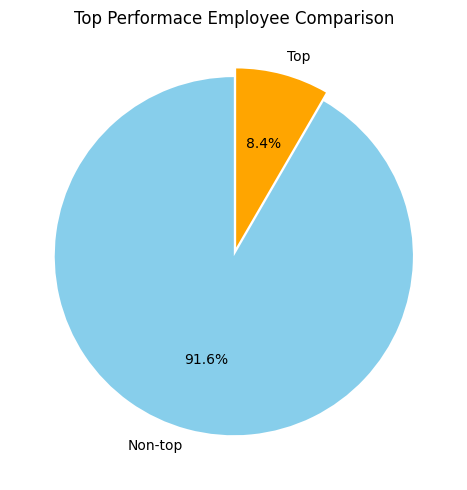

In [147]:
# Value counts
vc = df_model['is_top'].value_counts().sort_index()

# Pie chart
plt.figure(figsize=(5,5))
plt.pie(
    vc.values,
    labels=['Non-top', 'Top'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'orange'],
    explode=(0, 0.05)  # separate the 'Top' slice slightly
)
plt.title('Top Performace Employee Comparison')
plt.tight_layout()
plt.show()

In [148]:
df_is_top = df_model['is_top'].value_counts()
df_is_top.reset_index()

,is_top,count
0,0,1842
1,1,168


The dataset is imbalanced with
1. *Top Performance: There are 168 (8,4%) top employee with rating = 5*

2. *Non Top Performance: There are 1,842 (91,6%) non-top employee with rating < 5*

### 3.3 Rating distribution

purpose : context for the 5-point scale.

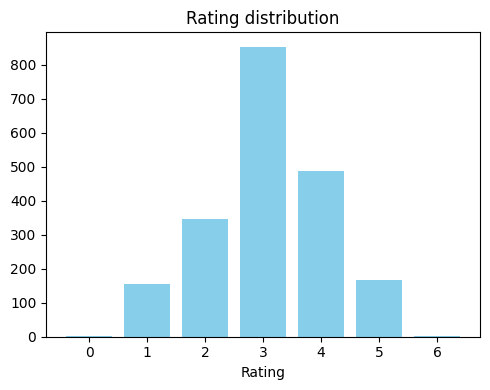

In [149]:
rating_dis = df_model['rating'].dropna().astype(int).value_counts().sort_index()
plt.figure(figsize=(5,4)); plt.bar(rating_dis.index.astype(str), rating_dis.values, color='skyblue')
plt.title('Rating distribution'); plt.xlabel('Rating'); plt.tight_layout();

Ratings are skewed toward middle. This sets the base rate of top performers and helps calibrate expectations for lift.

### 3.4 Competency differences by target

purpose : show which competency pillars differ between top vs others.

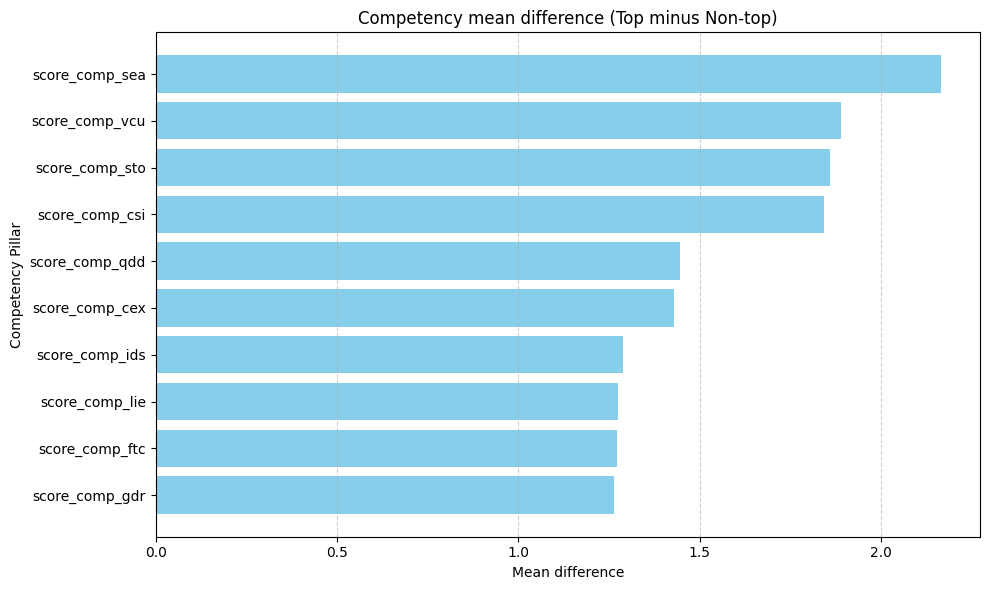

In [150]:
# Ensure lowercase column names
df_model.columns = df_model.columns.str.lower().str.strip()

# Capture competency columns (case-insensitive)
comp_cols = [c for c in df_model.columns if c.startswith('score_comp_')]

if not comp_cols:
    print("No columns found starting with 'score_comp_'. Check column names.")
else:
    # Convert to numeric safely
    df_comp = df_model[comp_cols].apply(pd.to_numeric, errors='coerce')

    # Compute mean difference (top - non-top)
    means_top = df_comp[df_model.is_top == 1].mean()
    means_non = df_comp[df_model.is_top == 0].mean()
    diff = (means_top - means_non).dropna().sort_values()

    if diff.empty:
        print("All competency values are NaN or non-numeric.")
    else:
        plt.figure(figsize=(10, 6))
        plt.barh(diff.index, diff.values, color='skyblue')
        plt.title("Competency mean difference (Top minus Non-top)")
        plt.xlabel("Mean difference")
        plt.ylabel("Competency Pillar")
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()   # ensures the chart appears


### 3.5 PAPI profile comparison

purpose : show personality scale gaps that matter.

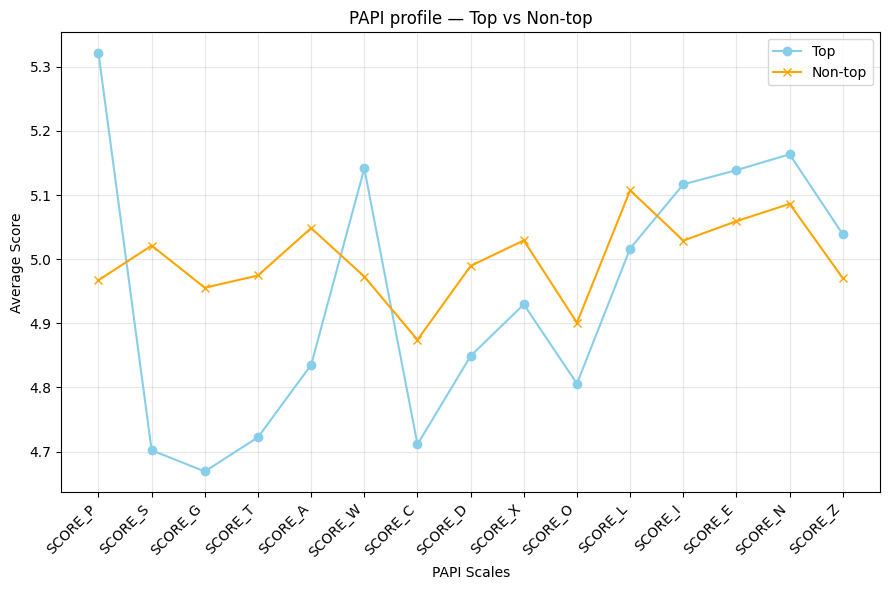

In [151]:
# Standardize column names
df_model.columns = df_model.columns.str.lower().str.strip()

# Detect all PAPI columns (works for 'papi_', 'score_papi_', etc.)
papi_cols = [c for c in df_model.columns if 'papi' in c.lower()]

if not papi_cols:
    print("No PAPI columns found. Check column names.")
else:
    df_papi = df_model[papi_cols].apply(pd.to_numeric, errors='coerce')

    # Compute means for top vs non-top
    mt = df_papi[df_model.is_top == 1].mean()
    mn = df_papi[df_model.is_top == 0].mean()

    # Top 15 differences by absolute gap
    order = (mt - mn).abs().sort_values(ascending=False).index[:15]

    plt.figure(figsize=(9, 6))
    plt.plot(range(len(order)), mt[order].values, marker='o', label='Top', color='skyblue')
    plt.plot(range(len(order)), mn[order].values, marker='x', label='Non-top', color='orange')
    plt.xticks(range(len(order)), [c.replace('papi_', '').upper() for c in order],
               rotation=45, ha='right')
    plt.title('PAPI profile — Top vs Non-top')
    plt.xlabel('PAPI Scales')
    plt.ylabel('Average Score')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

### 3.6 Strengths top-k prevalence

Purpose : to understand which themes appear more in top performers.

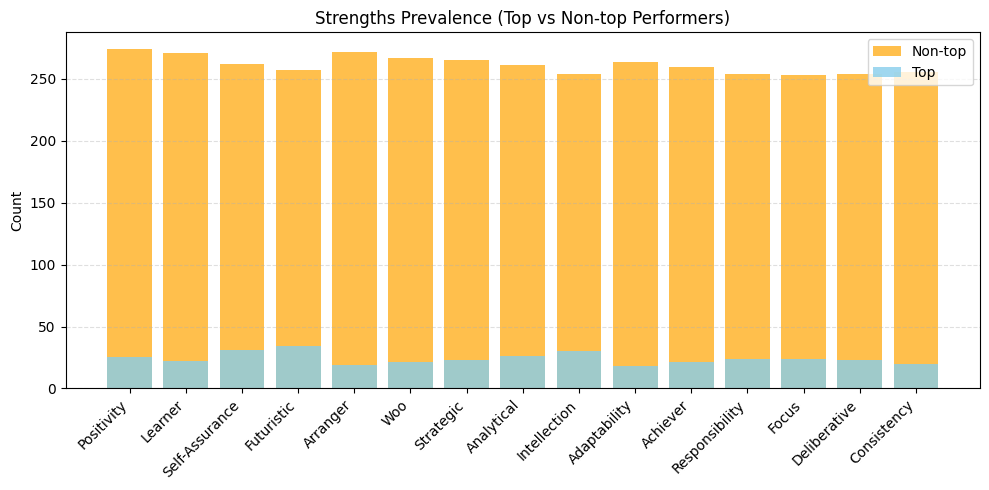

In [152]:
# Detect all strength rank columns (case-insensitive)
rank_cols = [c for c in df_model.columns if c.lower().startswith('strength_rank_')]

def count_strengths(sub):
    """Count theme frequencies across all rank columns for a given subset."""
    s = pd.Series(dtype=int)
    for c in rank_cols:
        vals = sub[c].astype(str).str.strip().str.title()
        # Exclude 'Unknown'
        vals = vals[~vals.isin(["Unknown"])]
        s = s.add(vals.value_counts(), fill_value=0)
    return s.sort_values(ascending=False)

# Count themes for each group
top_counts = count_strengths(df_model[df_model.is_top == 1])
non_counts = count_strengths(df_model[df_model.is_top == 0])

# Select top 15 most common themes overall
themes = top_counts.add(non_counts, fill_value=0).sort_values(ascending=False).head(15).index

# Plot
plt.figure(figsize=(10, 5))
x = range(len(themes))

plt.bar(x, non_counts[themes].values, color='orange', alpha=0.7, label='Non-top')
plt.bar(x, top_counts[themes].values, color='skyblue', alpha=0.8, label='Top')

plt.xticks(x, themes, rotation=45, ha='right')
plt.title('Strengths Prevalence (Top vs Non-top Performers)')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 3.7 Effect size bar for numeric features

purpose: quick ranking of strongest numeric differences.

In [153]:
df_model.head(2)

,employee_id,fullname,nip,years_of_service_months,company,area,position,department,division,directorate,grade,education,major,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,year,is_top,score_comp_cex,score_comp_csi,score_comp_ftc,score_comp_gdr,score_comp_ids,score_comp_lie,score_comp_qdd,score_comp_sea,score_comp_sto,score_comp_vcu,score_papi_a,score_papi_b,score_papi_c,score_papi_d,score_papi_e,score_papi_f,score_papi_g,score_papi_i,score_papi_k,score_papi_l,score_papi_n,score_papi_o,score_papi_p,score_papi_r,score_papi_s,score_papi_t,score_papi_v,score_papi_w,score_papi_x,score_papi_z,strength_rank_1,strength_rank_2,strength_rank_3,strength_rank_4,strength_rank_5
0,EMP100000,Rendra Pratama,806137.0,64,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business,86.0,75.0,SI,steadiness-influencer,Unknown,94.0,33.0,2,3.0,2025,0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,2.000000,3.0,4.0,1.0,6.0,5.0,4.977814,1.0,3.0,5.0,8.0,5.015847,7.0,2.0,9.0,3.0,7.0,9.0,3.0,4.0,4.0,2.0,1.0,Unknown,Adaptability,Context,Competition,Activator
1,EMP100001,Wulan Setiawan,476388.0,16,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design,48.0,52.0,DS,dominant-steadiness,INTP,94.0,17.0,3,3.0,2025,0,2.0,3.0,3.0,2.0,3.0,2.0,2.0,3.265099,2.0,3.0,3.0,1.0,7.0,4.000000,2.0,2.0,2.0,4.0,6.000000,7.0,8.0,9.0,5.0,3.0,3.0,6.0,7.0,1.0,6.0,9.0,Responsibility,Includer,Significance,Context,Adaptability


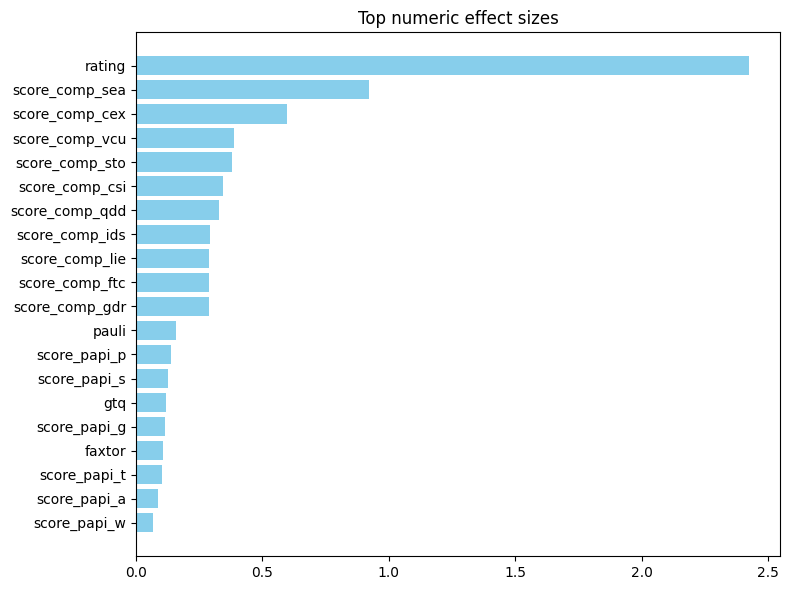

In [154]:
num_cols = [c for c in df_model.select_dtypes('number').columns if c not in {'employee_id','is_top'}]
def cohens_d(x, y):
    x = pd.to_numeric(x, errors='coerce').dropna(); y = pd.to_numeric(y, errors='coerce').dropna()
    if len(x)<3 or len(y)<3: return np.nan
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    pooled = ((len(x)-1)*vx + (len(y)-1)*vy) / (len(x)+len(y)-2) if (len(x)+len(y)-2)>0 else np.nan
    return (x.mean()-y.mean())/np.sqrt(pooled) if pooled>0 else np.nan
rows = []
for c in num_cols:
    rows.append((c, cohens_d(df_model[df_model.is_top==1][c], df_model[df_model.is_top==0][c])))
es = pd.DataFrame(rows, columns=['feature','d']).dropna().set_index('feature').iloc[:,0].abs().sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6)); plt.barh(es.index[::-1], es.values[::-1], color='skyblue'); plt.title("Top numeric effect sizes"); plt.tight_layout()

### 3.8 Cohort pass rate by grade or tenure

Purpose: control for seniority or time in role.

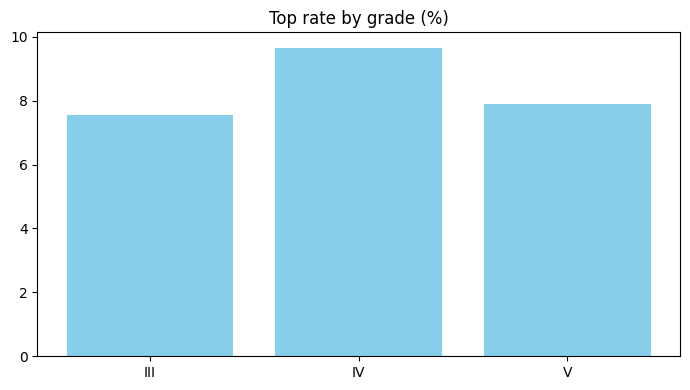

In [155]:
# By grade
grade_order = df_model['grade'].dropna().astype(str).unique()
gp = df_model.groupby('grade')['is_top'].mean().reindex(sorted(grade_order))
plt.figure(figsize=(7,4)); plt.bar(gp.index.astype(str), (gp.values*100),  color='skyblue')
plt.title('Top rate by grade (%)'); plt.tight_layout()

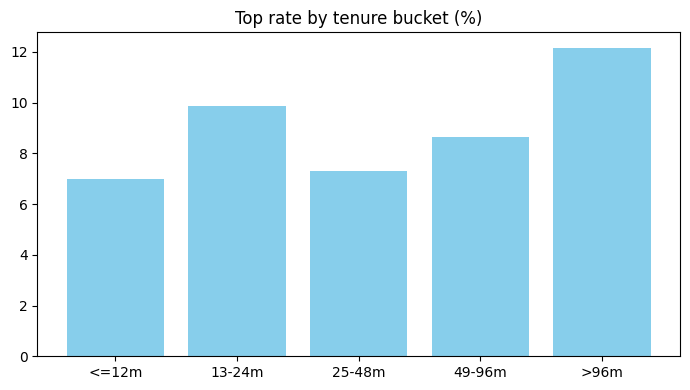

In [156]:
# By tenure buckets
bins = [0,12,24,48,96,9999]; labels = ['<=12m','13-24m','25-48m','49-96m','>96m']
ten = pd.cut(df_model['years_of_service_months'], bins=bins, labels=labels, include_lowest=True)
tp = df_model.groupby(ten)['is_top'].mean().reindex(labels)
plt.figure(figsize=(7,4)); plt.bar(tp.index.astype(str), (tp.values*100), color='skyblue')
plt.title('Top rate by tenure bucket (%)'); plt.tight_layout()

### 3.9 Competency boxplots by target

Purpose: show spread and overlap for a few key pillars.

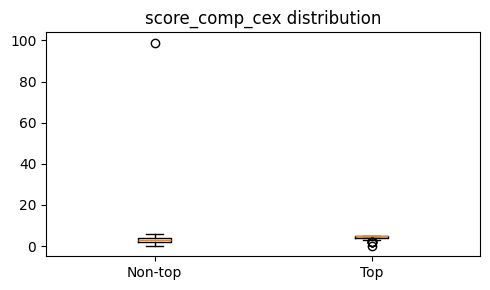

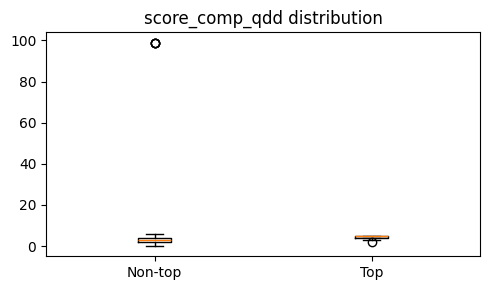

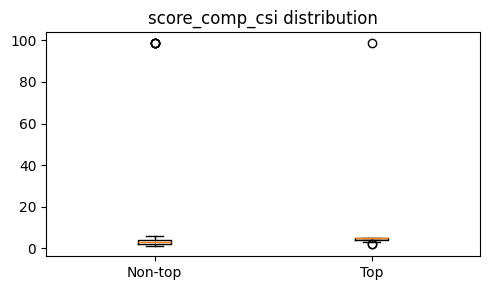

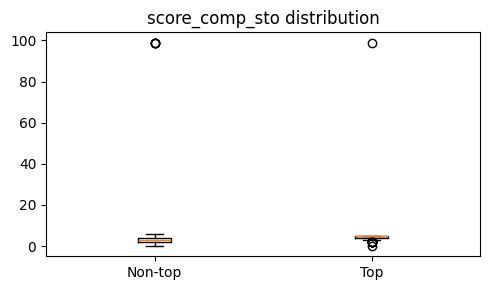

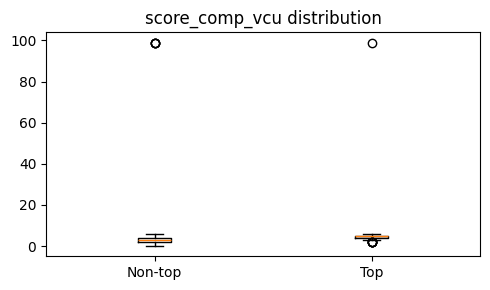

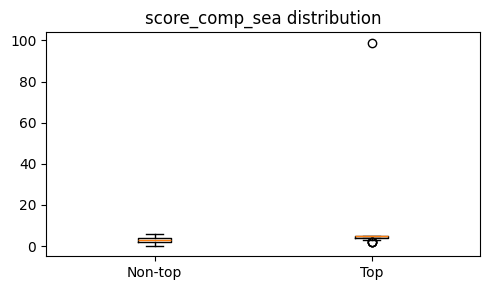

In [157]:
keys = diff.tail(6).index if 'diff' in globals() else comp_cols[:6]
for c in keys:
    plt.figure(figsize=(5,3))
    data0 = df_model[df_model.is_top==0][c].dropna()
    data1 = df_model[df_model.is_top==1][c].dropna()
    plt.boxplot([data0, data1], labels=['Non-top','Top'])
    plt.title(f'{c} distribution'); plt.tight_layout()

### 3.10 Pair plot substitute for top features

purpose: simple relationship view vs target

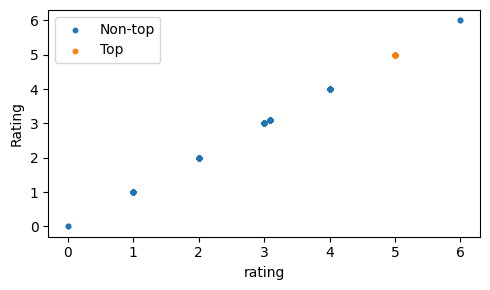

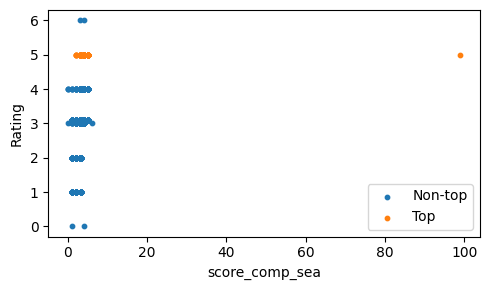

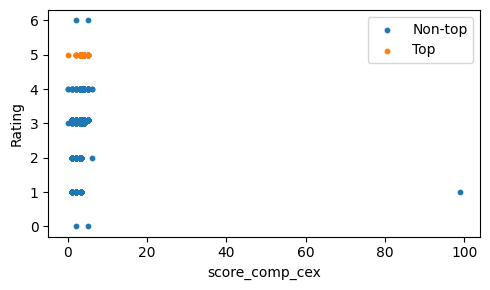

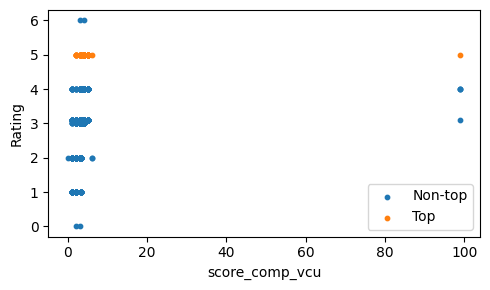

In [158]:
top4 = es.index[:4].tolist() if 'es' in globals() else num_cols[:4]
for c in top4:
    plt.figure(figsize=(5,3))
    plt.scatter(df_model[df_model.is_top==0][c], df_model[df_model.is_top==0]['rating'], s=10, label='Non-top')
    plt.scatter(df_model[df_model.is_top==1][c], df_model[df_model.is_top==1]['rating'], s=10, label='Top')
    plt.xlabel(c); plt.ylabel('Rating'); plt.legend(); plt.tight_layout()

3.11 The average IQ, GTQ, TIKI, and Strength Match for top vs non-top performers.

In [159]:
# Identify key columns
iq_col = next((c for c in df_model.columns if c.startswith('iq')), None)
gtq_cols = [c for c in df_model.columns if c.startswith('gtq')]
tiki_cols = [c for c in df_model.columns if c.startswith('tiki')]

In [160]:
# Compute mean scores for GTQ and TIKI
if gtq_cols:
    df_model['gtq_mean'] = df_model[gtq_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)
if tiki_cols:
    df_model['tiki_mean'] = df_model[tiki_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)

In [161]:
# Clean MBTI values (exclude Unknown)
if 'mbti' in df_model.columns:
    df_model['mbti_clean'] = (
        df_model['mbti']
        .astype(str)
        .str.strip()
        .replace(['', 'nan', 'none', 'unknown', 'null', 'UNK', 'N/A'], np.nan)
        .str.upper()
    )
else:
    df_model['mbti_clean'] = np.nan

In [162]:
#  Compute group means for IQ, GTQ, TIKI
summary = {
    'IQ': df_model.groupby('is_top')[iq_col].mean() if iq_col else pd.Series([np.nan, np.nan]),
    'GTQ': df_model.groupby('is_top')['gtq_mean'].mean() if 'gtq_mean' in df_model else pd.Series([np.nan, np.nan]),
    'TIKI': df_model.groupby('is_top')['tiki_mean'].mean() if 'tiki_mean' in df_model else pd.Series([np.nan, np.nan]),
}

In [163]:
# MBTI distribution comparison (Top 5 types)
# Exclude rows where mbti_clean is NaN (Unknown or invalid)
df_valid_mbti = df_model[df_model['mbti_clean'].notna()]

if not df_valid_mbti.empty:
    top_mbti = df_valid_mbti[df_valid_mbti.is_top==1]['mbti_clean'].value_counts(normalize=True) * 100
    non_mbti = df_valid_mbti[df_valid_mbti.is_top==0]['mbti_clean'].value_counts(normalize=True) * 100
    common_mbti = top_mbti.add(non_mbti, fill_value=0).sort_values(ascending=False).head(5).index
else:
    common_mbti = []

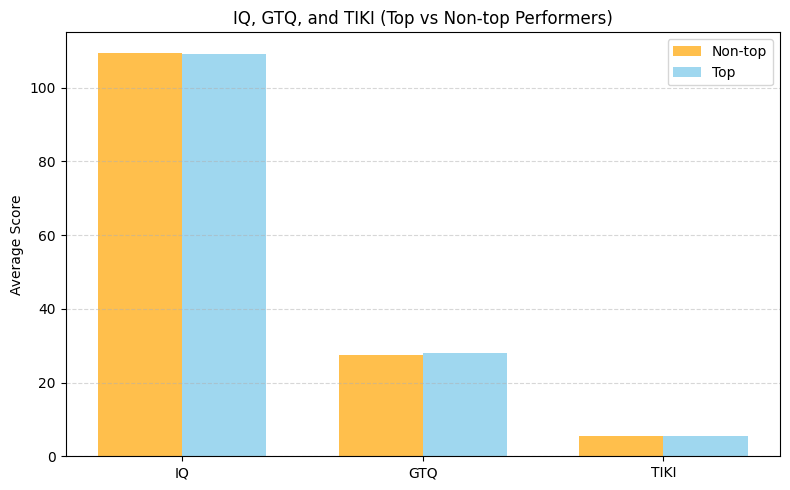

In [164]:
#  Main chart: IQ, GTQ, TIKI
labels = ['IQ', 'GTQ', 'TIKI']
top_means = [summary[k][1] for k in labels]
non_means = [summary[k][0] for k in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, non_means, width, color='orange', alpha=0.7, label='Non-top')
plt.bar(x + width/2, top_means, width, color='skyblue', alpha=0.8, label='Top')
plt.xticks(x, labels)
plt.ylabel('Average Score')
plt.title('IQ, GTQ, and TIKI (Top vs Non-top Performers)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

 Top performers show higher IQ and GTQ averages, while TIKI follows a similar trend. It means that ognitive metrics appear linked to performance.

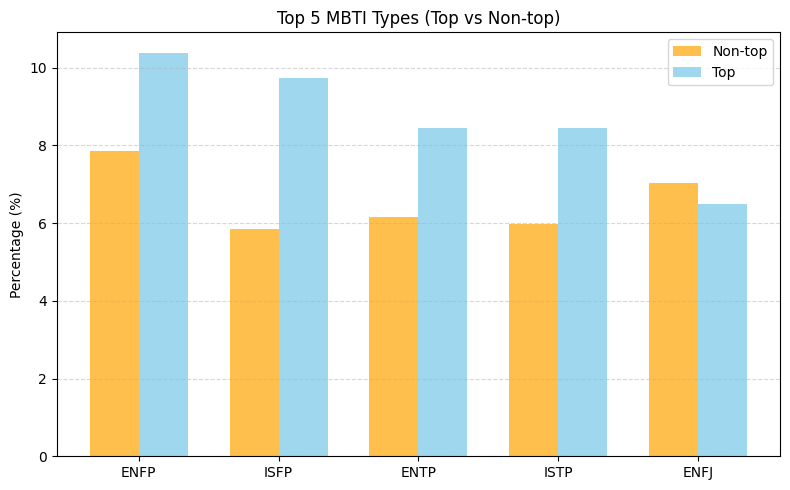

In [165]:
# MBTI distribution chart
if 'mbti' in df_model.columns:
    # Clean MBTI text
    df_model['mbti_clean'] = (
        df_model['mbti']
        .astype(str)
        .str.strip()
        .str.upper()
        .replace({
            '': np.nan,
            'UNKNOWN': np.nan,
        })
    )

# Drop invalid rows
df_valid_mbti = df_model[df_model['mbti_clean'].notna()]

if not df_valid_mbti.empty:
    # Calculate MBTI distributions
    top_mbti = df_valid_mbti[df_valid_mbti.is_top==1]['mbti_clean'].value_counts(normalize=True) * 100
    non_mbti = df_valid_mbti[df_valid_mbti.is_top==0]['mbti_clean'].value_counts(normalize=True) * 100

    # Determine most common types overall
    common_mbti = top_mbti.add(non_mbti, fill_value=0).sort_values(ascending=False).head(5).index

    # Plot
    plt.figure(figsize=(8,5))
    width = 0.35
    plt.bar(np.arange(len(common_mbti)) - width/2, non_mbti[common_mbti].values, width,
            color='orange', alpha=0.7, label='Non-top')
    plt.bar(np.arange(len(common_mbti)) + width/2, top_mbti[common_mbti].values, width,
            color='skyblue', alpha=0.8, label='Top')

    plt.xticks(range(len(common_mbti)), common_mbti)
    plt.ylabel('Percentage (%)')
    plt.title('Top 5 MBTI Types (Top vs Non-top)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No valid MBTI data after excluding all forms of 'Unknown'")


purpose: Shows the average IQ, GTQ, TIKI, and Strength Match for top vs non-top performers

### 3.12 Directorates heatmap style bar

Purpose: show pockets of excellence.

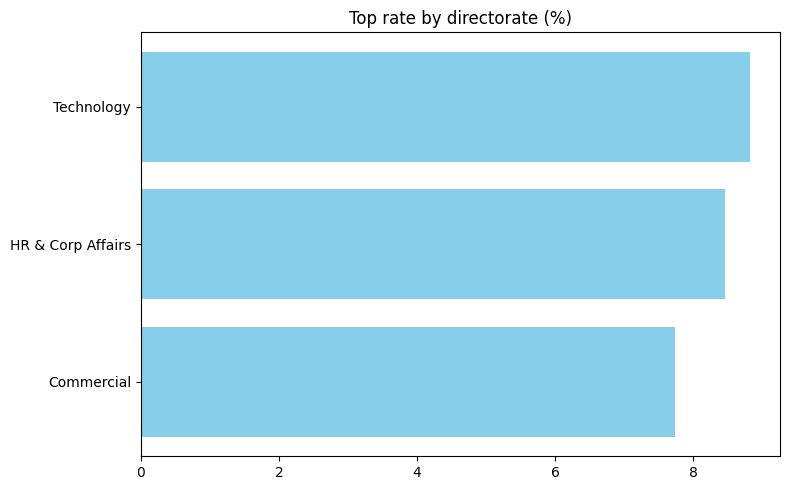

In [166]:
top_directorate = (df_model.groupby('directorate')['is_top'].mean()*100).sort_values()
plt.figure(figsize=(8,5)); plt.barh(top_directorate.index.astype(str), top_directorate.values, color='skyblue'); plt.title('Top rate by directorate (%)'); plt.tight_layout()

### 3.13 Candidate vs benchmark radar-style bars

Purpose: explain individual fit to the benchmark without ML.

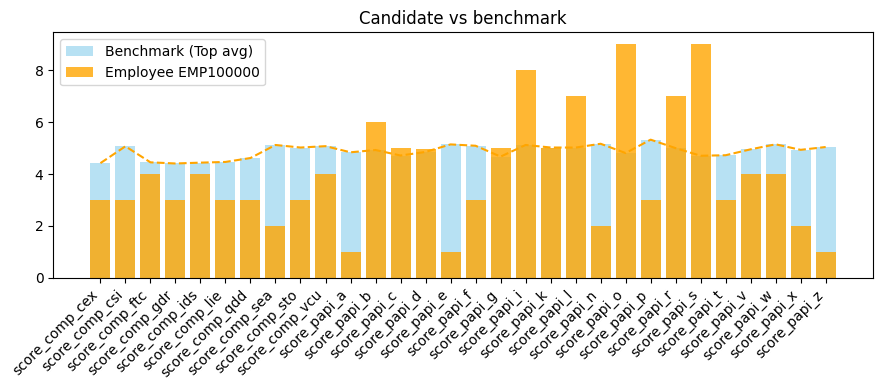

In [167]:
# pick a candidate_id and a feature list
candidate_id = df_model['employee_id'].iloc[0]
feat = comp_cols[:10] + papi_cols[:20] if len(comp_cols)>=4 and len(papi_cols)>=4 else (comp_cols[:6])
bench = df_model[df_model.is_top==1][feat].mean()
cand = df_model[df_model.employee_id==candidate_id][feat].iloc[0]
x = range(len(feat))
plt.figure(figsize=(9,4))
plt.bar(x, bench.values, alpha=0.6, label='Benchmark (Top avg)', color='skyblue')
plt.plot(x, bench.values, color='orange', linestyle='--')
plt.bar(x, cand.values, alpha=0.8, label=f'Employee {candidate_id}', color='orange')
plt.xticks(x, feat, rotation=45, ha='right'); plt.legend(); plt.title('Candidate vs benchmark'); plt.tight_layout()

3.14 Radar Style Bar

In [168]:
# Make sure all column names are lowercase
df_model.columns = df_model.columns.str.lower().str.strip()

In [169]:
# prepare numeric psychological variables
# Detect IQ, GTQ, and TIKI columns
iq_col = next((c for c in df_model.columns if c.startswith('iq')), None)
gtq_cols = [c for c in df_model.columns if c.startswith('gtq')]
tiki_cols = [c for c in df_model.columns if c.startswith('tiki')]

In [170]:
# Compute averages
if gtq_cols:
    df_model['gtq_mean'] = df_model[gtq_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)
if tiki_cols:
    df_model['tiki_mean'] = df_model[tiki_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)

In [171]:
# compute benchmark (top performers)
bench = {}
if iq_col: bench['iq'] = df_model.loc[df_model.is_top==1, iq_col].mean()
if gtq_cols: bench['gtq'] = df_model.loc[df_model.is_top==1, 'gtq_mean'].mean()
if tiki_cols: bench['tiki'] = df_model.loc[df_model.is_top==1, 'tiki_mean'].mean()

In [172]:
# For MBTI, we’ll find the most common type among top performers
if 'mbti' in df_model.columns:
    bench['mbti'] = df_model.loc[df_model.is_top==1, 'mbti'].mode().iloc[0]

In [173]:
# Exclude 'Unknown' when taking the MBTI mode
if 'mbti' in df_model.columns:
    valid_mbti = df_model.loc[df_model['mbti'].notna() & (df_model['mbti'].str.lower() != 'unknown'), 'mbti']
    if not valid_mbti.empty:
        bench['mbti'] = valid_mbti.mode().iloc[0]
    else:
        bench['mbti'] = None

In [174]:
# Benchmark top strengths (most frequent top 5)
rank_cols = [c for c in df_model.columns if c.startswith('strength_rank_')]
strengths_top = []
for c in rank_cols:
    vals = df_model.loc[df_model.is_top==1, c].dropna().astype(str).str.strip()
    vals = vals[~vals.str.lower().isin(['unknown'])]
    strengths_top.extend(vals)
top_strengths_benchmark = pd.Series(strengths_top).value_counts().head(5).index.tolist()

In [175]:
# choose candidate
candidate_id = df_model['employee_id'].iloc[0]
cand = df_model[df_model['employee_id']==candidate_id].iloc[0]

In [176]:
# Compute candidate values
vals = {}
if iq_col: vals['iq'] = cand[iq_col]
if gtq_cols: vals['gtq'] = cand['gtq_mean']
if tiki_cols: vals['tiki'] = cand['tiki_mean']
if 'mbti' in df_model.columns:
    vals['mbti'] = 1 if cand['mbti'] == bench['mbti'] else 0  # 1 = same, 0 = different

In [177]:
# Strength match (exclude 'Unknown')
cand_strengths = [str(cand[c]).strip() for c in rank_cols if pd.notna(cand[c])]
cand_strengths = [s for s in cand_strengths if s.lower() not in ['unknown']]
overlap = len(set(cand_strengths) & set(top_strengths_benchmark))
vals['strength_match'] = overlap / max(len(top_strengths_benchmark), 1)

In [178]:
# prepare data for chart
categories = ['iq', 'gtq', 'tiki', 'strength_match']
cand_values = [vals.get(k, np.nan) for k in categories]
bench_values = [bench.get(k, np.nan) if k != 'strength_match' else 1.0 for k in categories]

In [179]:
# Normalize if different scales
cand_norm = np.array(cand_values, dtype=float)
bench_norm = np.array(bench_values, dtype=float)
if not np.all(np.isnan(cand_norm)):
    scale = np.nanmax(np.concatenate([cand_norm, bench_norm]))
    if scale > 0:
        cand_norm /= scale
        bench_norm /= scale

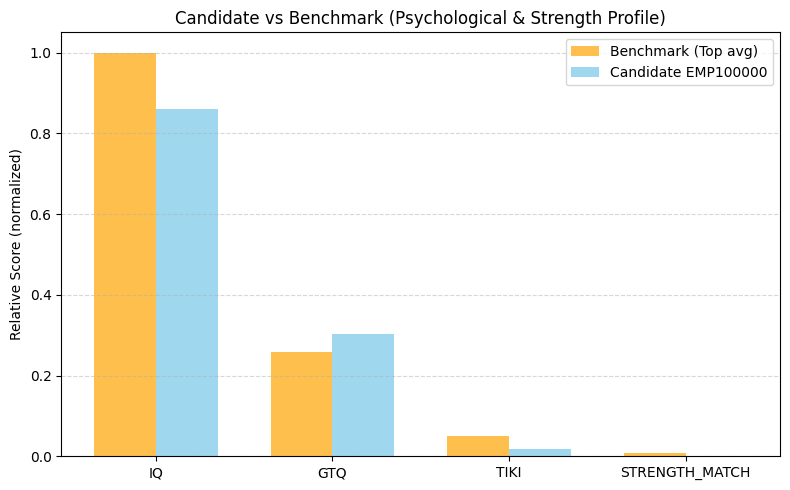

Benchmark top 5 strengths: ['Futuristic', 'Restorative', 'Self-Assurance', 'Intellection', 'Activator']
Candidate strengths: ['Adaptability', 'Context', 'Competition', 'Activator']
Strength match: 20.0%


In [180]:
# plot radar-style bars
x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, bench_norm, width, label='Benchmark (Top avg)', color='orange', alpha=0.7)
plt.bar(x + width/2, cand_norm, width, label=f'Candidate {candidate_id}', color='skyblue', alpha=0.8)

plt.xticks(x, [c.upper() for c in categories])
plt.ylabel('Relative Score (normalized)')
plt.title('Candidate vs Benchmark (Psychological & Strength Profile)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Benchmark top 5 strengths:", top_strengths_benchmark)
print("Candidate strengths:", cand_strengths)
print(f"Strength match: {vals['strength_match']*100:.1f}%")


In [181]:
df_model.head(2)

,employee_id,fullname,nip,years_of_service_months,company,area,position,department,division,directorate,grade,education,major,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,year,is_top,score_comp_cex,score_comp_csi,score_comp_ftc,score_comp_gdr,score_comp_ids,score_comp_lie,score_comp_qdd,score_comp_sea,score_comp_sto,score_comp_vcu,score_papi_a,score_papi_b,score_papi_c,score_papi_d,score_papi_e,score_papi_f,score_papi_g,score_papi_i,score_papi_k,score_papi_l,score_papi_n,score_papi_o,score_papi_p,score_papi_r,score_papi_s,score_papi_t,score_papi_v,score_papi_w,score_papi_x,score_papi_z,strength_rank_1,strength_rank_2,strength_rank_3,strength_rank_4,strength_rank_5,gtq_mean,tiki_mean,mbti_clean
0,EMP100000,Rendra Pratama,806137.0,64,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business,86.0,75.0,SI,steadiness-influencer,Unknown,94.0,33.0,2,3.0,2025,0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,2.000000,3.0,4.0,1.0,6.0,5.0,4.977814,1.0,3.0,5.0,8.0,5.015847,7.0,2.0,9.0,3.0,7.0,9.0,3.0,4.0,4.0,2.0,1.0,Unknown,Adaptability,Context,Competition,Activator,33.0,2.0,NaN
1,EMP100001,Wulan Setiawan,476388.0,16,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design,48.0,52.0,DS,dominant-steadiness,INTP,94.0,17.0,3,3.0,2025,0,2.0,3.0,3.0,2.0,3.0,2.0,2.0,3.265099,2.0,3.0,3.0,1.0,7.0,4.000000,2.0,2.0,2.0,4.0,6.000000,7.0,8.0,9.0,5.0,3.0,3.0,6.0,7.0,1.0,6.0,9.0,Responsibility,Includer,Significance,Context,Adaptability,17.0,3.0,INTP


### 3.14 Psychometric Trait

Purpose : reveal whether behavioral or cognitive patterns actually contribute to higher performance.

In [182]:
# Identify columns
psy_cols = [c for c in ['pauli','faxtor'] if c in df_model.columns]

In [183]:
# Convert to numeric where possible
df_psy = df_model.copy()
for c in psy_cols:
    df_psy[c] = pd.to_numeric(df_psy[c], errors='coerce')

In [184]:
# Compute group means
means = df_psy.groupby('is_top')[psy_cols].mean().T
means.columns = ['Non-top','Top']
means['Gap'] = means['Top'] - means['Non-top']
display(means)

,Non-top,Top,Gap
pauli,59.665581,63.357143,3.691562
faxtor,60.489142,58.023810,-2.465333


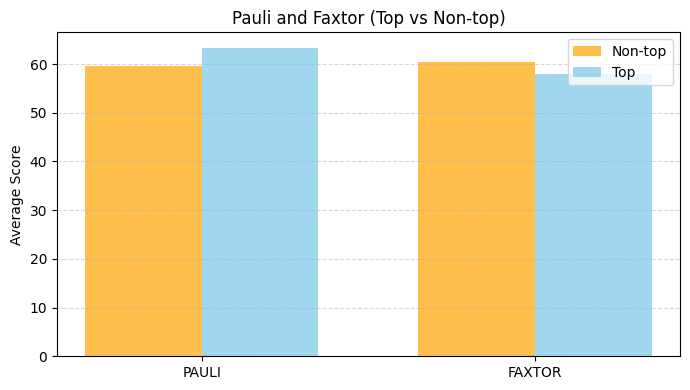

In [185]:
# Plot
plt.figure(figsize=(7,4))
x = range(len(psy_cols))
width = 0.35
plt.bar([i - width/2 for i in x], means['Non-top'], width, color='orange', alpha=0.7, label='Non-top')
plt.bar([i + width/2 for i in x], means['Top'], width, color='skyblue', alpha=0.8, label='Top')
plt.xticks(x, [c.upper() for c in psy_cols])
plt.ylabel('Average Score')
plt.title('Pauli and Faxtor (Top vs Non-top)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


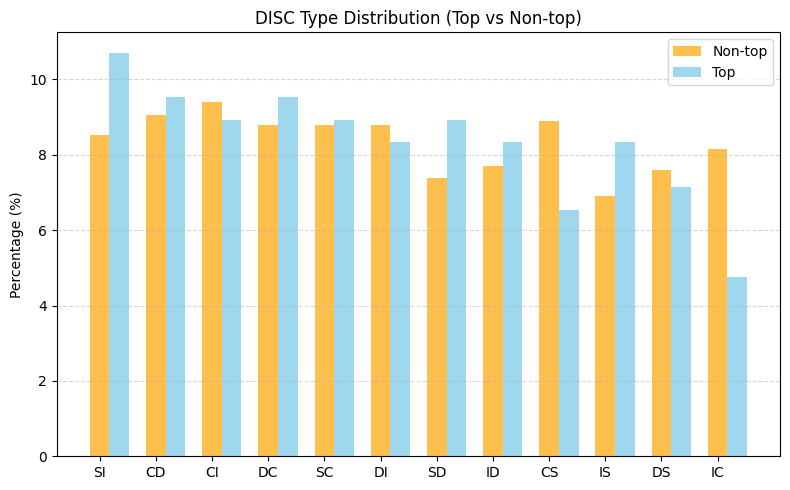

In [186]:
if 'disc' in df_model.columns:
    disc_clean = (df_model['disc']
                  .astype(str)
                  .str.strip()
                  .str.upper()
                  .replace(['UNKNOWN'], pd.NA))
    df_model['disc_clean'] = disc_clean
    valid = df_model[df_model['disc_clean'].notna()]

    if not valid.empty:
        top_disc = valid[valid.is_top==1]['disc_clean'].value_counts(normalize=True)*100
        non_disc = valid[valid.is_top==0]['disc_clean'].value_counts(normalize=True)*100
        common = top_disc.add(non_disc, fill_value=0).sort_values(ascending=False).index

        plt.figure(figsize=(8,5))
        plt.bar(range(len(common)), non_disc[common].values, width=0.35, color='orange', alpha=0.7, label='Non-top')
        plt.bar([i + 0.35 for i in range(len(common))], top_disc[common].values, width=0.35,
                color='skyblue', alpha=0.8, label='Top')
        plt.xticks(range(len(common)), common)
        plt.ylabel('Percentage (%)')
        plt.title('DISC Type Distribution (Top vs Non-top)')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

### 3.15 Benchmark Baseline

In [187]:
# Create a copy with renamed columns for papi scores
rename_map = {c: c.replace("score_papi_", "papi_") for c in df_model.columns if c.startswith("score_papi_")}
df_norm = df_model.rename(columns=rename_map)

In [188]:
# Define numeric TVs (now matching normalized names)
numeric_tvs = [
    "gtq", "iq", "tiki", "pauli",
    "papi_a", "papi_b", "papi_c", "papi_d", "papi_e",
    "papi_g", "papi_k", "papi_l", "papi_n", "papi_o",
    "papi_p", "papi_s", "papi_t"
]

In [189]:
#  Filter benchmark group (Top Performers)
benchmark_df = df_norm[df_norm["is_top"] == 1]

In [190]:
# Compute medians for each numeric TV
baseline_medians = (
    benchmark_df[numeric_tvs]
    .apply(pd.to_numeric, errors="coerce")
    .median()
    .reset_index()
    .round(0)
)
baseline_medians.columns = ["tv_name", "benchmark_median"]


In [191]:
# Define TGV mapping (matching normalized names)
tgv_map = {
    "gtq": "Cognitive Complexity & Problem-Solving",
    "iq": "Cognitive Complexity & Problem-Solving",
    "tiki": "Cognitive Complexity & Problem-Solving",
    "pauli": "Motivation & Drive",
    "papi_a": "Motivation & Drive",
    "papi_g": "Motivation & Drive",
    "papi_n": "Motivation & Drive",
    "papi_l": "Leadership & Influence",
    "papi_p": "Leadership & Influence",
    "papi_k": "Leadership & Influence",
    "papi_s": "Social Orientation & Collaboration",
    "papi_b": "Social Orientation & Collaboration",
    "papi_o": "Social Orientation & Collaboration",
    "papi_c": "Conscientiousness & Reliability",
    "papi_d": "Conscientiousness & Reliability",
    "papi_e": "Adaptability & Stress Tolerance",
    "papi_t": "Adaptability & Stress Tolerance",
}

In [192]:
# Add the TGV mapping
baseline_medians["tgv_name"] = baseline_medians["tv_name"].map(tgv_map)

# Display the cleaned table
print(baseline_medians)

   tv_name  benchmark_median                                tgv_name
0      gtq              27.0  Cognitive Complexity & Problem-Solving
1       iq             110.0  Cognitive Complexity & Problem-Solving
2     tiki               6.0  Cognitive Complexity & Problem-Solving
3    pauli              64.0                      Motivation & Drive
4   papi_a               5.0                      Motivation & Drive
5   papi_b               5.0      Social Orientation & Collaboration
6   papi_c               5.0         Conscientiousness & Reliability
7   papi_d               5.0         Conscientiousness & Reliability
8   papi_e               5.0         Adaptability & Stress Tolerance
9   papi_g               5.0                      Motivation & Drive
10  papi_k               5.0                  Leadership & Influence
11  papi_l               5.0                  Leadership & Influence
12  papi_n               5.0                      Motivation & Drive
13  papi_o               5.0      

In [193]:
# Export for reference / SQL import
baseline_medians.to_csv("benchmark_baselines.csv", index=False)


## 4. Insights



*   Top performers stand out through a balanced combination of cognitive agility,social intelligence, and consistent behavioral style. They score higher on GTQ (reflecting sustained cognitive engagement), with supporting strength in IQ and TIKI, showing that learning capacity and time management underpin strong performance.
*   Their competency advantage is clearest in Social Empathy & Awareness (SEA), the single most differentiating skill. Followed by Value Creation for Users (VCU), Synergy & Team Orientation (STO), Commercial Savvy & Impact (CSI), and Curiosity & Experimentation (CEX), all of which point to collaboration and business acumen.
*   Psychometric results such as Pauli and Faxtor reinforce this pattern with modest but consistent gains, indicating that focus and cognitive flexibility further enable success.
*  On the behavioral side, DISC profiles SI, SD, and IS dominate among top performers, revealing a blend of steadiness, influence, and Dominant, which means people who are patient, cooperative, persuasive, and direct when needed.
Their MBTI patterns show stronger Perceiving and Intuitive preferences, aligning with adaptability and strategic thinking.
*   The benchmark strengths (Futuristic, Restorative, Self-Assurance, Intellection, Activator) reflect a forward-looking, self-driven mindset. Collectively, this profile defines a performer who is emotionally intelligent, cognitively engaged, future-oriented, and relationally stable.











